In [ ]:
# Import required libraries
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats, signal
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# 🔹 1. Authenticate & Initialize Earth Engine with Project ID
PROJECT_ID = "ee-deepeshy"

try:
    ee.Initialize(project=PROJECT_ID)  # Try initializing GEE with project
    print("Earth Engine initialized successfully!")
except ee.EEException:
    print("Authentication required. Please follow the instructions.")
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)

In [ ]:
# Define study area (Bangalore)
CITY_COORDS = [77.5946, 12.9716]  # [longitude, latitude]
CITY_POINT = ee.Geometry.Point(CITY_COORDS)
REGION = CITY_POINT.buffer(10000)  # 10km buffer

# Set date range
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5*365)  # 5 years of data

In [ ]:
def get_ndvi_data(start_date, end_date):
    print("Collecting NDVI data...")

    def calculate_ndvi_l8(image):
        ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
        qa = image.select('QA_PIXEL')
        clear = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 4).eq(0))
        return ndvi.updateMask(clear)

    dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    ndvi_values = []

    for date in dates:
        start_month = (date - pd.Timedelta(days=15)).strftime('%Y-%m-%d')
        end_month = (date + pd.Timedelta(days=15)).strftime('%Y-%m-%d')

        try:
            ndvi_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
                .filterBounds(REGION) \
                .filterDate(start_month, end_month) \
                .filter(ee.Filter.lt('CLOUD_COVER', 70))

            count = ndvi_collection.size().getInfo()

            if count > 0:
                ndvi_image = ndvi_collection.map(calculate_ndvi_l8).mean()
                ndvi_value = ndvi_image.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=REGION,
                    scale=30,
                    maxPixels=1e9
                ).get('NDVI').getInfo()

                ndvi_values.append(ndvi_value if ndvi_value is not None else None)
            else:
                print(f"No images found for {date}")
                ndvi_values.append(None)

        except Exception as e:
            print(f"Error processing NDVI for {date}: {str(e)}")
            ndvi_values.append(None)

    df = pd.DataFrame({'date': dates, 'NDVI': ndvi_values})
    df['NDVI'] = df['NDVI'].interpolate(method='linear', limit_direction='both')

    print(f"NDVI data collection completed. {df['NDVI'].count()} valid values collected.")
    return df


def get_temperature_data(start_date, end_date):
    print("Collecting temperature data...")

    dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    temp_values = []

    for date in dates:
        start_month = date.strftime('%Y-%m-01')
        end_month = (date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        try:
            era5_data = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
                .filterDate(start_month, end_month) \
                .select('temperature_2m') \
                .mean() \
                .reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=REGION,
                    scale=1000,
                    maxPixels=1e9
                ).get('temperature_2m').getInfo()

            # Convert from Kelvin to Celsius
            if era5_data is not None:
                temp_values.append(era5_data - 273.15)
            else:
                temp_values.append(None)

        except Exception as e:
            print(f"Error collecting temperature for {date}: {str(e)}")
            temp_values.append(None)

    df = pd.DataFrame({
        'date': dates,
        'temperature': temp_values
    })

    # Handle missing values
    df['temperature'] = df['temperature'].interpolate(method='linear', limit_direction='both')

    print(f"Temperature data collection completed. Range: {df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
    return df

def get_rainfall_data(start_date, end_date):
    print("Collecting rainfall data...")

    dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    precip_values = []

    for date in dates:
        # Get start and end of month
        start_month = date.strftime('%Y-%m-01')
        end_month = (date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        # Get CHIRPS data for the month
        chirps_data = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filterDate(start_month, end_month) \
            .sum() \
            .reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=REGION,
                scale=500,
                maxPixels=1e9
            ).get('precipitation').getInfo()

        precip_values.append(chirps_data if chirps_data is not None else None)

    df = pd.DataFrame({
        'date': dates,
        'precipitation': precip_values
    })

    # Handle any None values through interpolation
    df['precipitation'] = df['precipitation'].interpolate(method='linear', limit_direction='both')

    return df

def get_air_quality_data(start_date, end_date):
    print("Collecting air quality data...")

    dates = pd.date_range(start=start_date, end=end_date, freq='ME')
    no2_values, aer_values = [], []

    for date in dates:
        start_month = date.strftime('%Y-%m-01')
        end_month = (date + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        try:
            no2_collection = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2') \
                .filterDate(start_month, end_month) \
                .select('NO2_column_number_density')

            aer_collection = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_AER_AI') \
                .filterDate(start_month, end_month) \
                .select('absorbing_aerosol_index')

            if no2_collection.size().getInfo() > 0:
                no2_data = no2_collection.mean().reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=REGION,
                    scale=1000,
                    maxPixels=1e9
                ).get('NO2_column_number_density', None)  # Handle missing keys

                no2_values.append(no2_data.getInfo() if no2_data is not None else None)
            else:
                no2_values.append(None)

            if aer_collection.size().getInfo() > 0:
                aer_data = aer_collection.mean().reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=REGION,
                    scale=1000,
                    maxPixels=1e9
                ).get('absorbing_aerosol_index', None)

                aer_values.append(aer_data.getInfo() if aer_data is not None else None)
            else:
                aer_values.append(None)

        except Exception as e:
            print(f"Error collecting air quality data for {date}: {str(e)}")
            no2_values.append(None)
            aer_values.append(None)

    df = pd.DataFrame({'date': dates, 'aqi_no2': no2_values, 'aqi_aer': aer_values})
    df['aqi_no2'] = df['aqi_no2'].interpolate(method='linear', limit_direction='both')
    df['aqi_aer'] = df['aqi_aer'].interpolate(method='linear', limit_direction='both')

    print("Air quality data collection completed.")
    return df

In [ ]:
def validate_data(df):
    print("\nData Validation:")
    print("-" * 50)

    for column in df.select_dtypes(include=[np.number]).columns:
        values = df[column].values
        n_unique = len(np.unique(values))
        std = np.std(values)

        print(f"\nColumn: {column}")
        print(f"Number of unique values: {n_unique}")
        print(f"Standard deviation: {std:.6f}")
        print(f"Range: {np.min(values):.6f} to {np.max(values):.6f}")
        print(f"Missing values: {df[column].isna().sum()}")

        # Additional checks
        if n_unique == 1:
            print("WARNING: Column has only one unique value!")
        if std < 1e-6:
            print("WARNING: Column has very low variation!")

        # Plot the time series
        plt.figure(figsize=(12, 4))
        plt.plot(df['date'], df[column], 'o-')
        plt.title(f'Time Series of {column}')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.grid(True)
        plt.show()

In [ ]:
def analyze_missing_values(df):
    # Calculate missing value statistics
    total_records = len(df)
    missing_stats = pd.DataFrame({
        'Total Records': total_records,
        'Missing Values': df.isnull().sum(),
        'Missing Percentage': (df.isnull().sum() / total_records * 100).round(2),
        'Available Records': df.count(),
        'Coverage Percentage': (df.count() / total_records * 100).round(2)
    })

    print("\nMissing Value Analysis:")
    display(missing_stats)

    # Identify temporal gaps
    df_sorted = df.sort_values('date')
    time_gaps = []

    for col in df.columns:
        if col != 'date':
            # Find gaps larger than 1 month
            non_null_dates = df_sorted[df_sorted[col].notnull()]['date']
            gaps = non_null_dates.diff()
            large_gaps = gaps[gaps > pd.Timedelta(days=30)]

            if not large_gaps.empty:
                print(f"\nTemporal gaps in {col}:")
                for gap in large_gaps:
                    print(f"Gap of {gap.days} days")

Starting data collection...
No images found for 2017-06-30 00:00:00
No images found for 2017-07-31 00:00:00
No images found for 2017-08-31 00:00:00
No images found for 2017-09-30 00:00:00
No images found for 2018-06-30 00:00:00
No images found for 2018-07-31 00:00:00
No images found for 2019-07-31 00:00:00
No images found for 2019-08-31 00:00:00
No images found for 2021-06-30 00:00:00
No images found for 2021-11-30 00:00:00
No images found for 2021-12-31 00:00:00
No images found for 2022-06-30 00:00:00
No images found for 2022-09-30 00:00:00
NDVI data collection completed. 72 valid values collected.
Temperature data collection completed. Range: 19.8°C to 28.0°C
Error collecting air quality data for 2020-12-31 00:00:00: Computation timed out.
Air quality data collection completed.

Data Validation:
--------------------------------------------------

Column: NDVI
Number of unique values: 72
Standard deviation: 0.047222
Range: 0.196571 to 0.464484
Missing values: 0


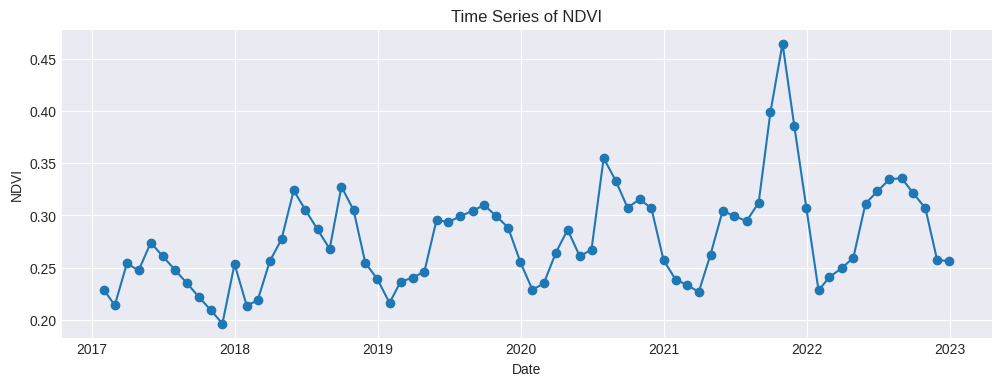


Column: precipitation
Number of unique values: 69
Standard deviation: 89.480575
Range: 0.000000 to 322.987705
Missing values: 0


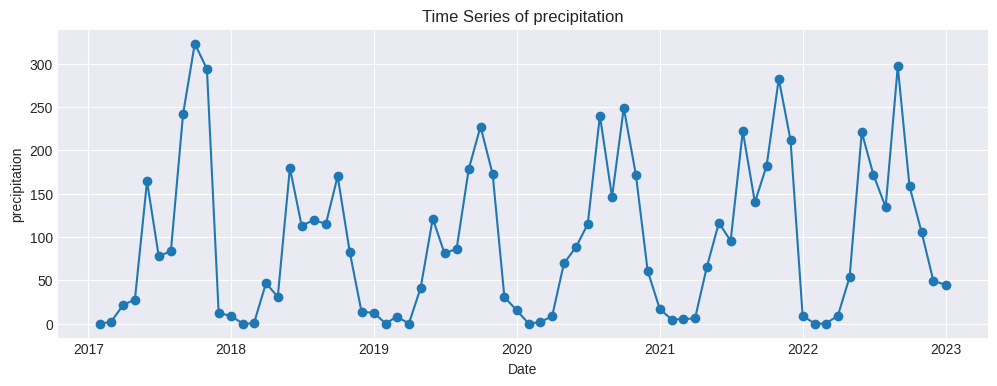


Column: temperature
Number of unique values: 72
Standard deviation: 2.018981
Range: 19.819585 to 27.980264
Missing values: 0


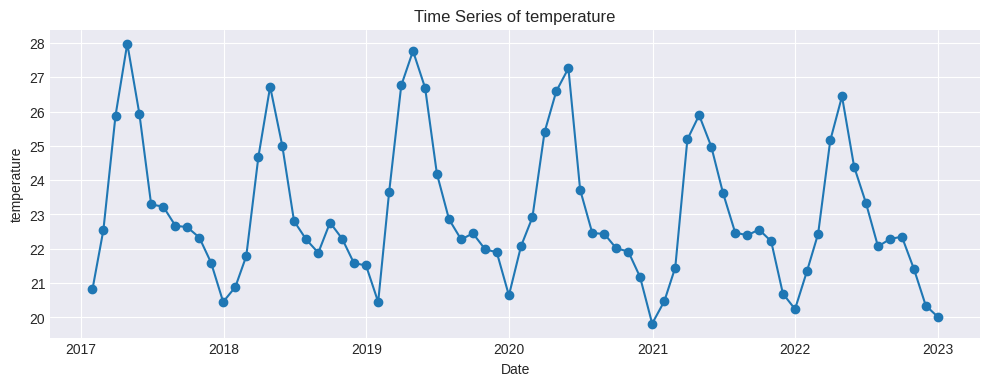


Column: aqi_no2
Number of unique values: 54
Standard deviation: 0.000022
Range: 0.000057 to 0.000143
Missing values: 0


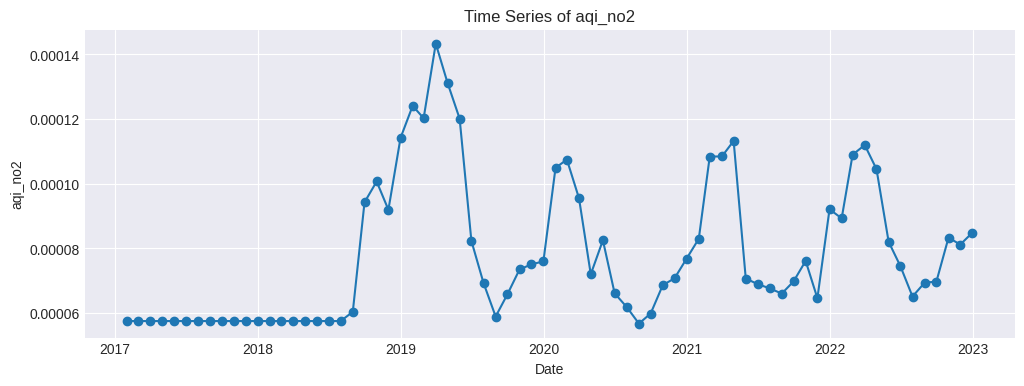


Column: aqi_aer
Number of unique values: 54
Standard deviation: 0.407835
Range: -1.632147 to -0.042388
Missing values: 0


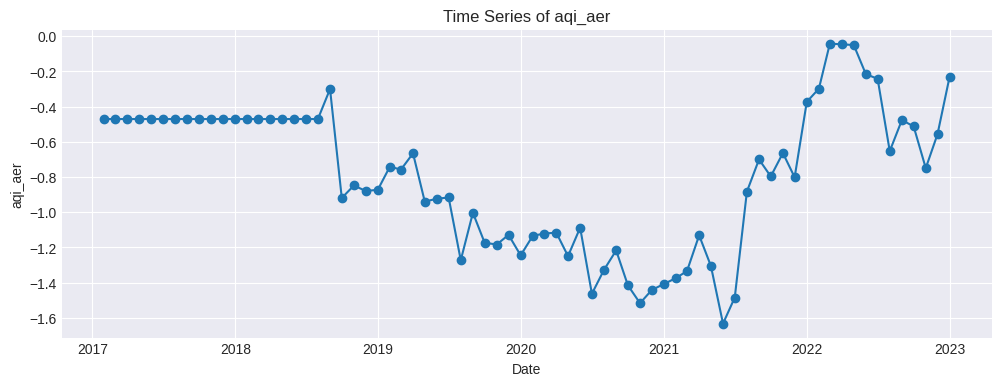


Summary Statistics:
                      date       NDVI  precipitation  temperature    aqi_no2  \
count                   72  72.000000      72.000000    72.000000  72.000000   
mean   2020-01-14 21:40:00   0.277507      95.134598    23.010044   0.000078   
min    2017-01-31 00:00:00   0.196571       0.000000    19.819585   0.000057   
25%    2018-07-23 06:00:00   0.240993      11.542014    21.738568   0.000058   
50%    2020-01-15 12:00:00   0.265970      79.170069    22.442703   0.000070   
75%    2021-07-07 18:00:00   0.306858     165.501054    24.239071   0.000092   
max    2022-12-31 00:00:00   0.464484     322.987705    27.980264   0.000143   
std                    NaN   0.047553      90.108516     2.033150   0.000022   

         aqi_aer  
count  72.000000  
mean   -0.788287  
min    -1.632147  
25%    -1.131737  
50%    -0.745057  
75%    -0.470701  
max    -0.042388  
std     0.410697  


In [12]:
# Set date range
START_DATE = '2017-01-01'
END_DATE = '2023-01-01'

# Collect data
print("Starting data collection...")
ndvi_df = get_ndvi_data(START_DATE, END_DATE)
rainfall_df = get_rainfall_data(START_DATE, END_DATE)
temp_df = get_temperature_data(START_DATE, END_DATE)
aqi_df = get_air_quality_data(START_DATE, END_DATE)

# # Merge all data
# all_data = ndvi_df.merge(rainfall_df, on='date', how='outer') \
#     .merge(temp_df, on='date', how='outer') \
#     .merge(aqi_df, on='date', how='outer')

# # Sort by date
# all_data = all_data.sort_values('date')

# # Validate the data
# validate_data(all_data)

# # Print summary statistics
# print("\nSummary Statistics:")
# print(all_data.describe())




# Merge all data
all_data = ndvi_df.merge(rainfall_df, on='date', how='outer') \
    .merge(temp_df, on='date', how='outer') \
    .merge(aqi_df, on='date', how='outer')

# Sort by date
all_data = all_data.sort_values('date')

# Fill missing NDVI values using interpolation
all_data['NDVI'] = all_data['NDVI'].interpolate(method='linear')

# Drop remaining missing values (if needed)
all_data.dropna(inplace=True)

# Validate the data
validate_data(all_data)

# Print summary statistics
print("\nSummary Statistics:")
print(all_data.describe())

In [9]:
# Merge all datasets
df = ndvi_df.merge(temp_df, on='date', how='outer')
df = df.merge(rainfall_df, on='date', how='outer')
df = df.merge(aqi_df, on='date', how='outer')
df = df.sort_values('date')

# Display initial data overview
print("\nInitial Data Overview:")
display(df.head())
print("\nBasic Statistics:")
display(df.describe())


Initial Data Overview:


,date,NDVI,temperature,precipitation,aqi_no2,aqi_aer
0,2017-01-31,0.229021,20.813769,0.009947,0.000058,-0.470701
1,2017-02-28,0.214028,22.548518,1.923682,0.000058,-0.470701
2,2017-03-31,0.254132,25.883866,21.516313,0.000058,-0.470701
3,2017-04-30,0.247430,27.980264,27.676434,0.000058,-0.470701
4,2017-05-31,0.274121,25.926658,164.019652,0.000058,-0.470701



Basic Statistics:


,date,NDVI,temperature,precipitation,aqi_no2,aqi_aer
count,72,72.000000,72.000000,72.000000,72.000000,72.000000
mean,2020-01-14 21:40:00,0.277507,23.010044,95.134598,0.000078,-0.787595
min,2017-01-31 00:00:00,0.196571,19.819585,0.000000,0.000057,-1.632147
25%,2018-07-23 06:00:00,0.240993,21.738568,11.542014,0.000058,-1.131737
50%,2020-01-15 12:00:00,0.265970,22.442703,79.170069,0.000070,-0.745057
75%,2021-07-07 18:00:00,0.306858,24.239071,165.501054,0.000092,-0.470701
max,2022-12-31 00:00:00,0.464484,27.980264,322.987705,0.000143,-0.042388
std,NaN,0.047553,2.033150,90.108516,0.000022,0.409680


<ipython-input-10-c5a21e777044>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned[column] = df_cleaned[column].fillna(method='bfill').fillna(method='ffill')


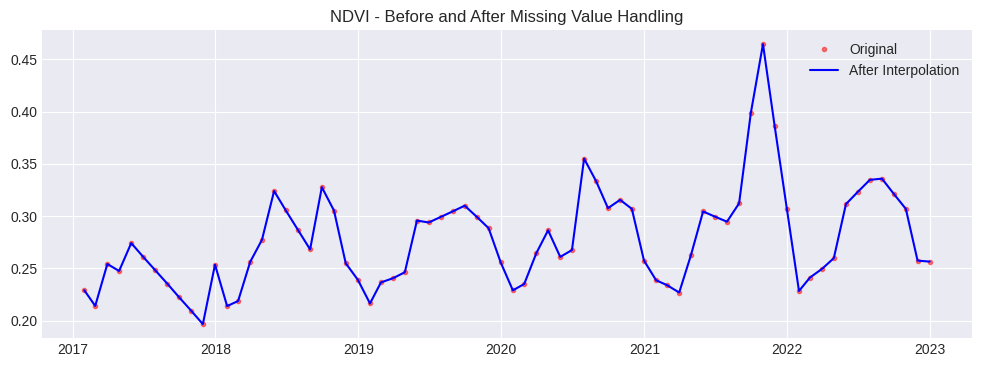

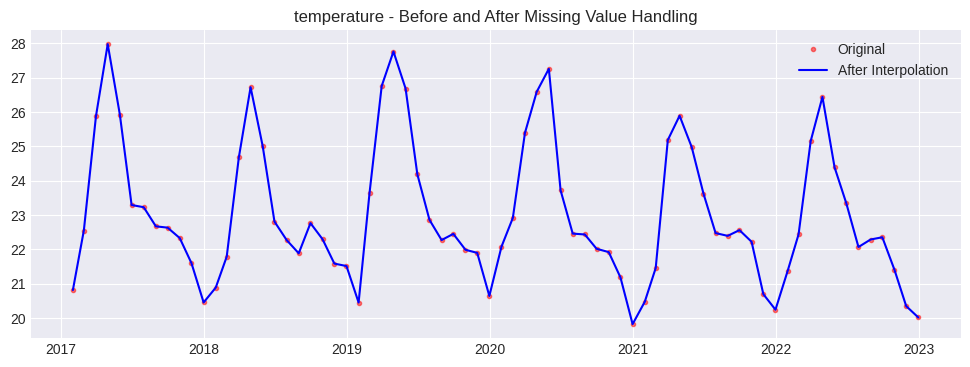

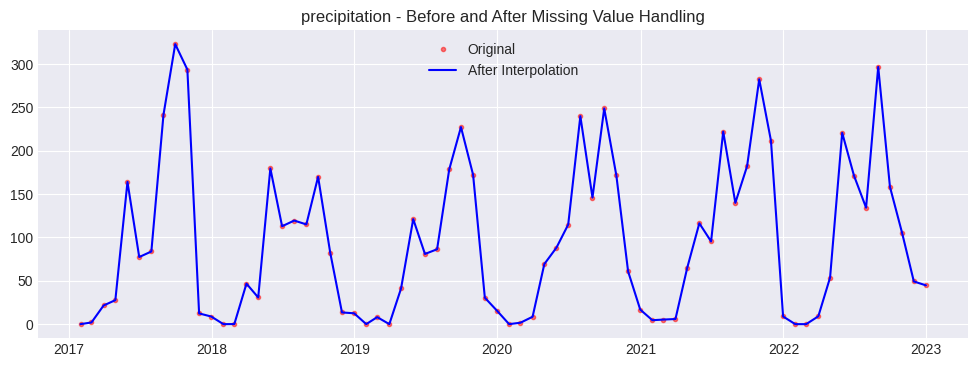

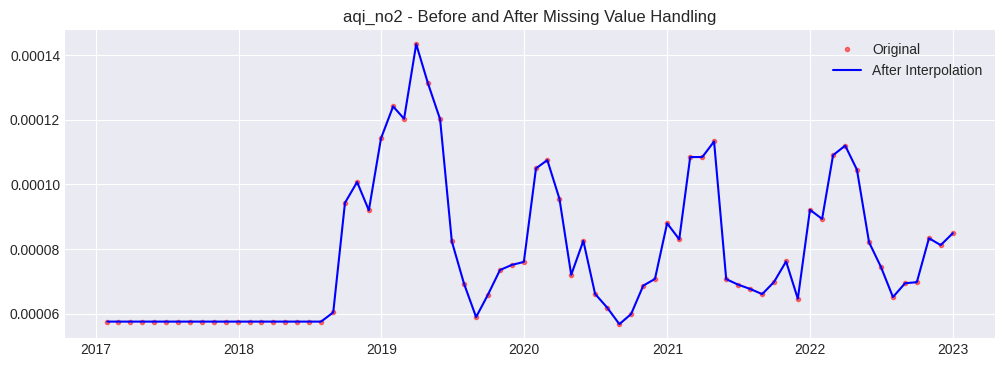

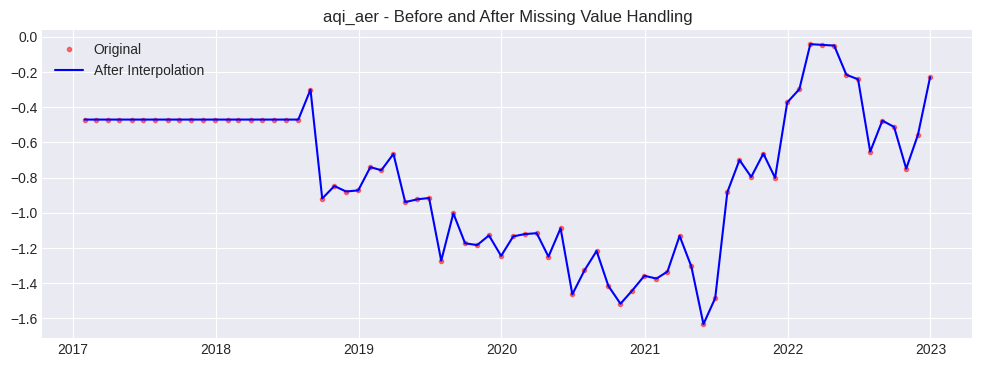

In [10]:
# Preprocessing Step 1: Handle Missing Values
def handle_missing_values(df):
    df_cleaned = df.copy()

    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # Linear interpolation
        df_cleaned[column] = df_cleaned[column].interpolate(method='linear')
        # Handle edges
        df_cleaned[column] = df_cleaned[column].fillna(method='bfill').fillna(method='ffill')

    return df_cleaned

df_cleaned = handle_missing_values(df)

variables = ['NDVI', 'temperature', 'precipitation', 'aqi_no2','aqi_aer']
# Visualize the effect of missing value handling
for var in variables:
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df[var], 'r.', label='Original', alpha=0.5)
    plt.plot(df_cleaned['date'], df_cleaned[var], 'b-', label='After Interpolation')
    plt.title(f'{var} - Before and After Missing Value Handling')
    plt.legend()
    plt.show()

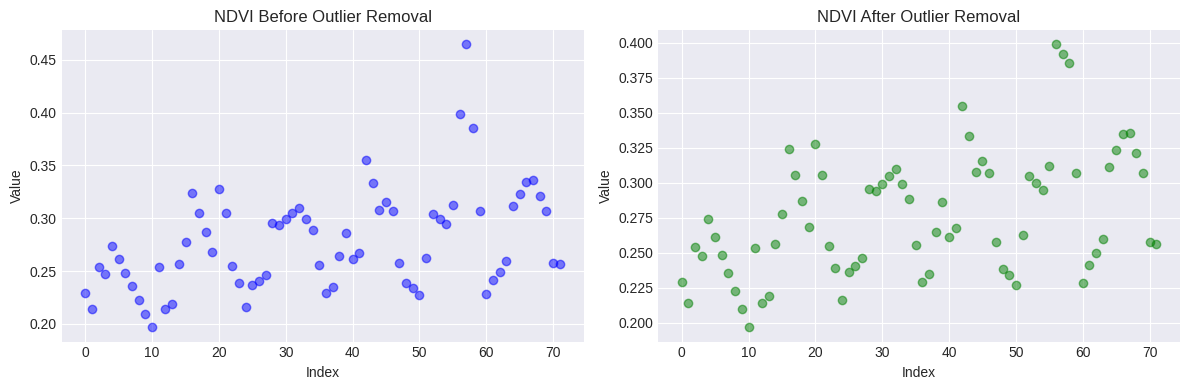

Number of outliers removed in NDVI: 1


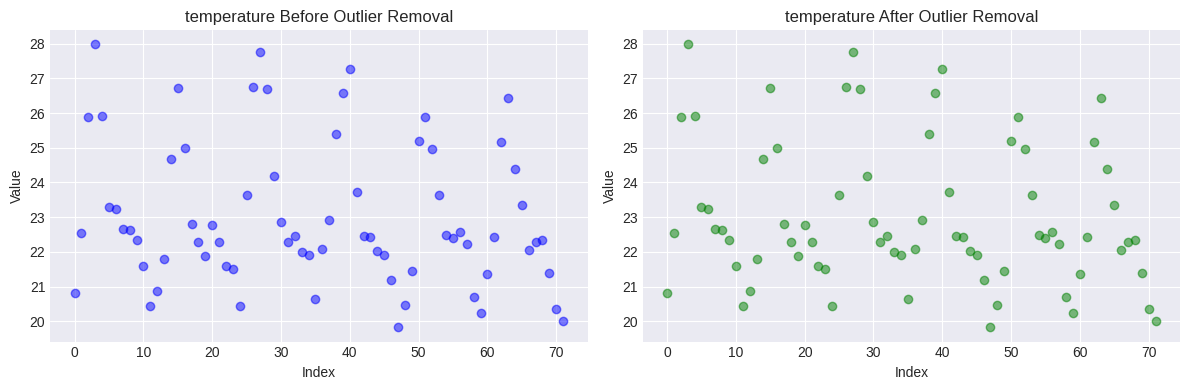

Number of outliers removed in temperature: 0


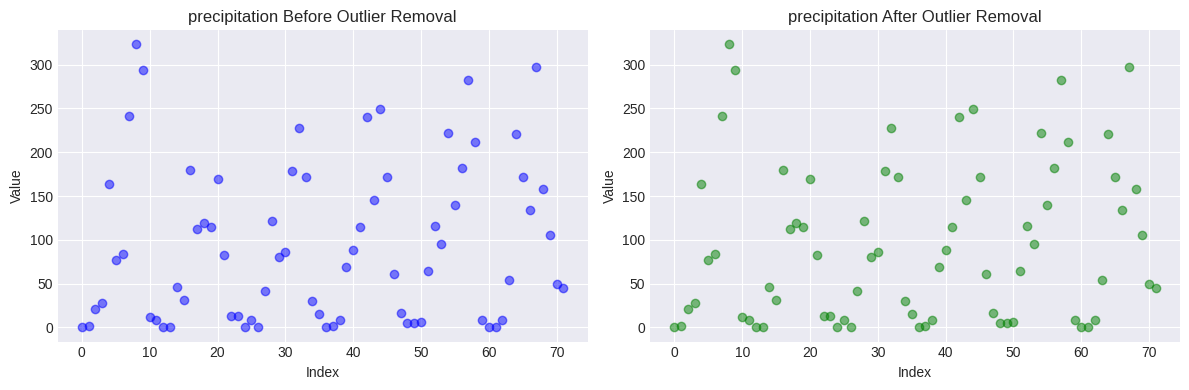

Number of outliers removed in precipitation: 0


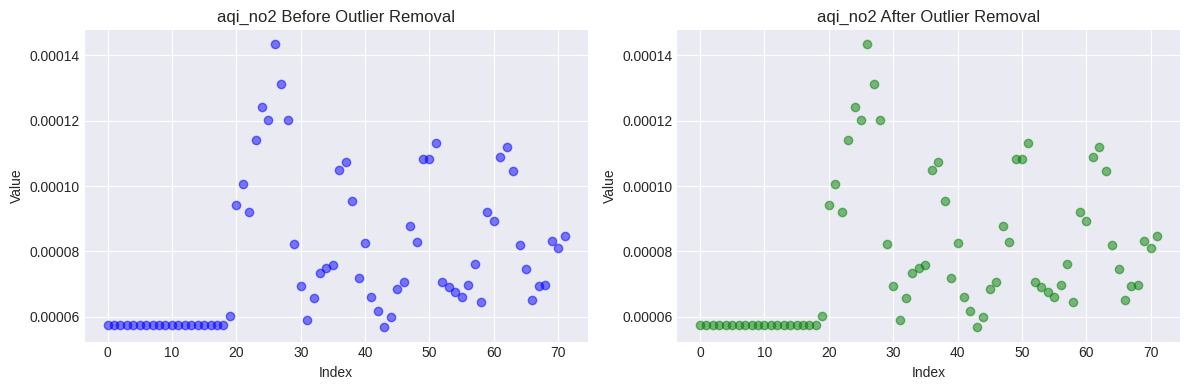

Number of outliers removed in aqi_no2: 0


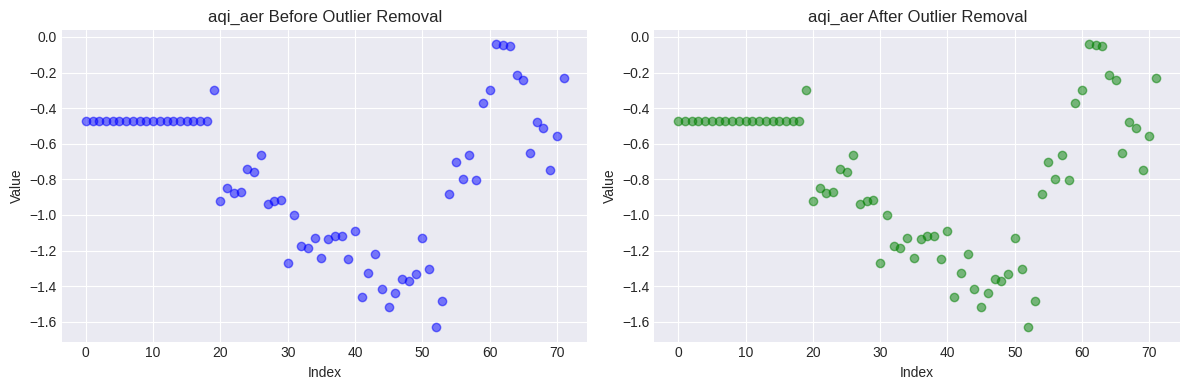

Number of outliers removed in aqi_aer: 0


In [11]:
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd

def remove_outliers(df, columns, threshold=3, min_std=1e-6):
    """
    Remove outliers from specified columns using z-score method and interpolate missing values.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    columns : list
        List of column names to process
    threshold : float, default=3
        Z-score threshold for outlier detection
    min_std : float, default=1e-6
        Minimum standard deviation threshold to apply outlier detection
    """
    df_no_outliers = df.copy()

    for column in columns:
        # Check if the column has enough variation to justify outlier removal
        std = df[column].std()
        if std < min_std:
            print(f"Warning: Column {column} has very low variation (std={std:.2e}). Skipping outlier removal.")
            continue

        valid_data = df_no_outliers[column].dropna()

        # Only proceed with outlier removal if we have enough variation
        z_scores = zscore(valid_data)
        mask = abs(z_scores) < threshold

        # Count potential outliers before removing them
        n_outliers = (~mask).sum()
        if n_outliers / len(mask) > 0.5:  # If more than 50% would be removed
            print(f"Warning: Too many outliers detected in {column} ({n_outliers} points). Skipping outlier removal.")
            continue

        # Create a full-length mask matching the original column
        full_mask = pd.Series(True, index=df_no_outliers.index)
        full_mask[valid_data.index] = mask

        # Mark outliers as NaN
        df_no_outliers.loc[~full_mask, column] = np.nan

        # Interpolate missing values
        df_no_outliers[column] = df_no_outliers[column].interpolate(
            method='linear',
            limit_direction='both'
        )

        # Visualization
        plt.figure(figsize=(12, 4))

        plt.subplot(121)
        plt.scatter(df[column].index, df[column], alpha=0.5, color='blue')
        plt.title(f'{column} Before Outlier Removal')
        plt.xlabel('Index')
        plt.ylabel('Value')

        plt.subplot(122)
        plt.scatter(df_no_outliers[column].index, df_no_outliers[column],
                   alpha=0.5, color='green')
        plt.title(f'{column} After Outlier Removal')
        plt.xlabel('Index')
        plt.ylabel('Value')

        plt.tight_layout()
        plt.show()

        print(f"Number of outliers removed in {column}: {n_outliers}")

    return df_no_outliers
# Example usage:
df_no_outliers = remove_outliers(df_cleaned, variables)

In [13]:
# Add this diagnostic code before calling remove_outliers
def diagnose_data(df, columns):
    print("\nData Diagnosis:")
    print("-" * 50)
    for column in columns:
        print(f"\nColumn: {column}")
        print(f"First few values: {df[column].head().tolist()}")
        print(f"Unique values count: {df[column].nunique()}")
        print(f"Min: {df[column].min()}")
        print(f"Max: {df[column].max()}")
        print(f"Mean: {df[column].mean()}")
        print(f"Std: {df[column].std()}")

# Use it before outlier removal
diagnose_data(df_cleaned, variables)


Data Diagnosis:
--------------------------------------------------

Column: NDVI
First few values: [0.22902058294839314, 0.21402783590065788, 0.2541319017083386, 0.24742980682207938, 0.27412138978658757]
Unique values count: 72
Min: 0.19657146995176802
Max: 0.464484286654439
Mean: 0.2775071397970454
Std: 0.04755322864404532

Column: temperature
First few values: [20.813769042795002, 22.548517762025483, 25.883865820155563, 27.980264045272634, 25.926657507764162]
Unique values count: 72
Min: 19.819585069456764
Max: 27.980264045272634
Mean: 23.010043539788043
Std: 2.033149651500438

Column: precipitation
First few values: [0.009947333937361712, 1.9236818603366295, 21.516312876590852, 27.67643438519576, 164.01965206358884]
Unique values count: 69
Min: 0.0
Max: 322.98770462764026
Mean: 95.13459812997787
Std: 90.10851627056776

Column: aqi_no2
First few values: [5.750598048752625e-05, 5.750598048752625e-05, 5.750598048752625e-05, 5.750598048752625e-05, 5.750598048752625e-05]
Unique values c

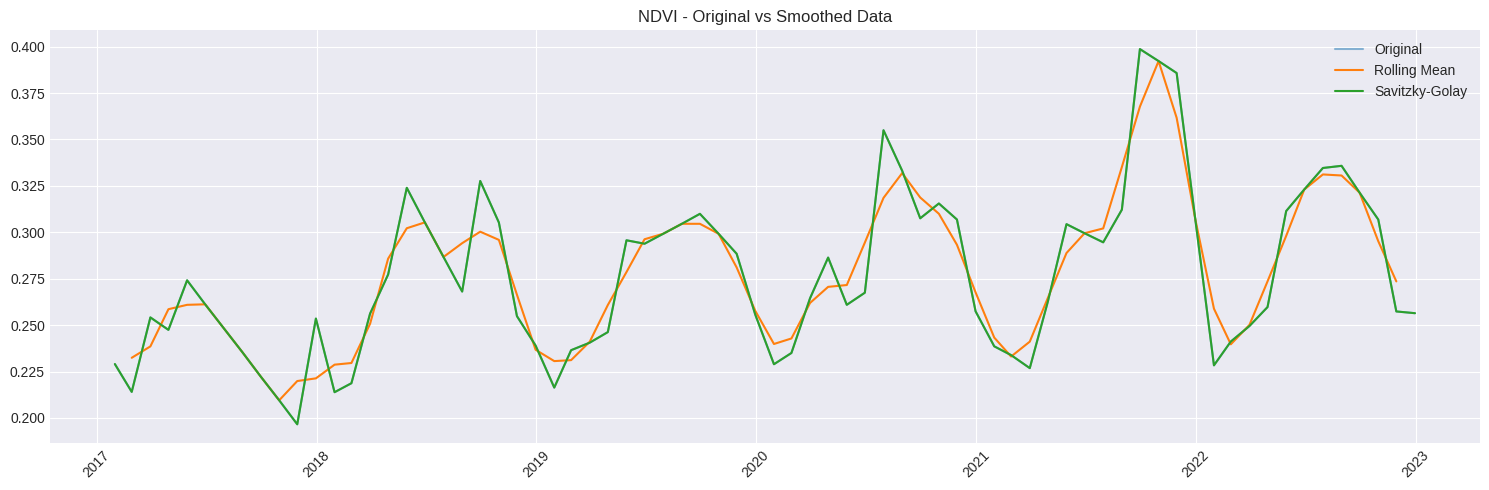

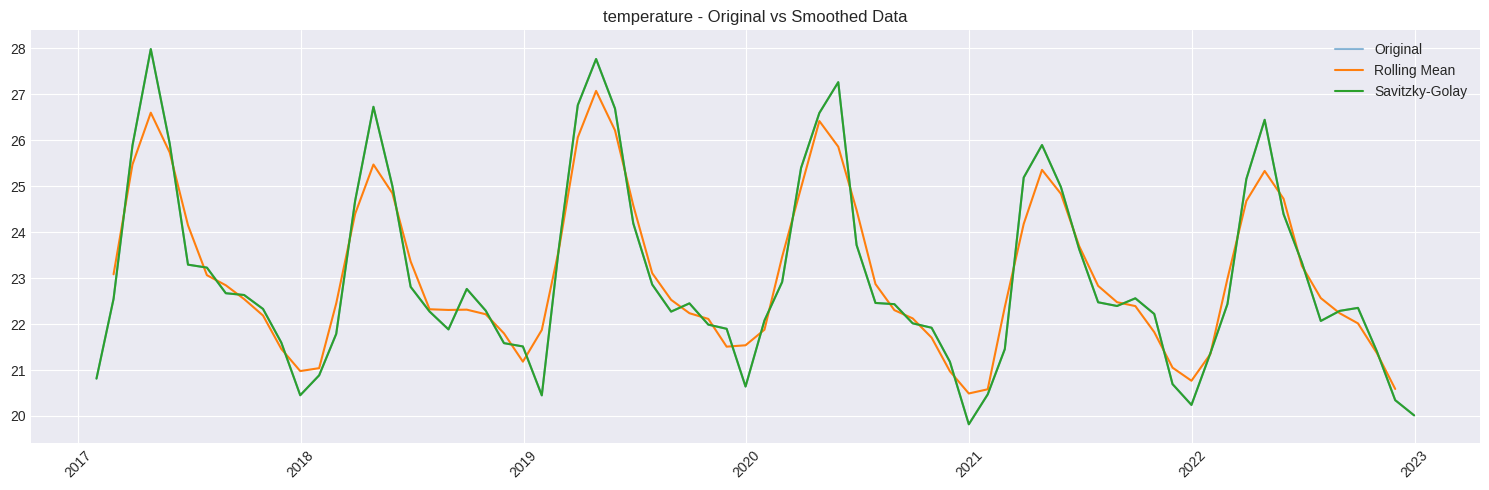

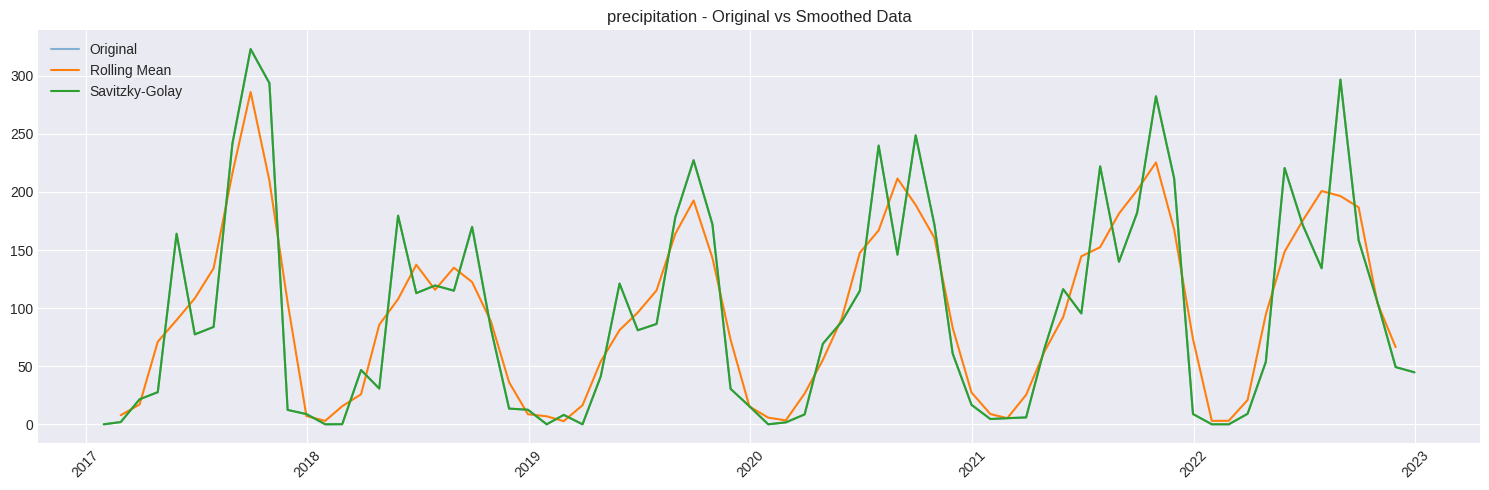

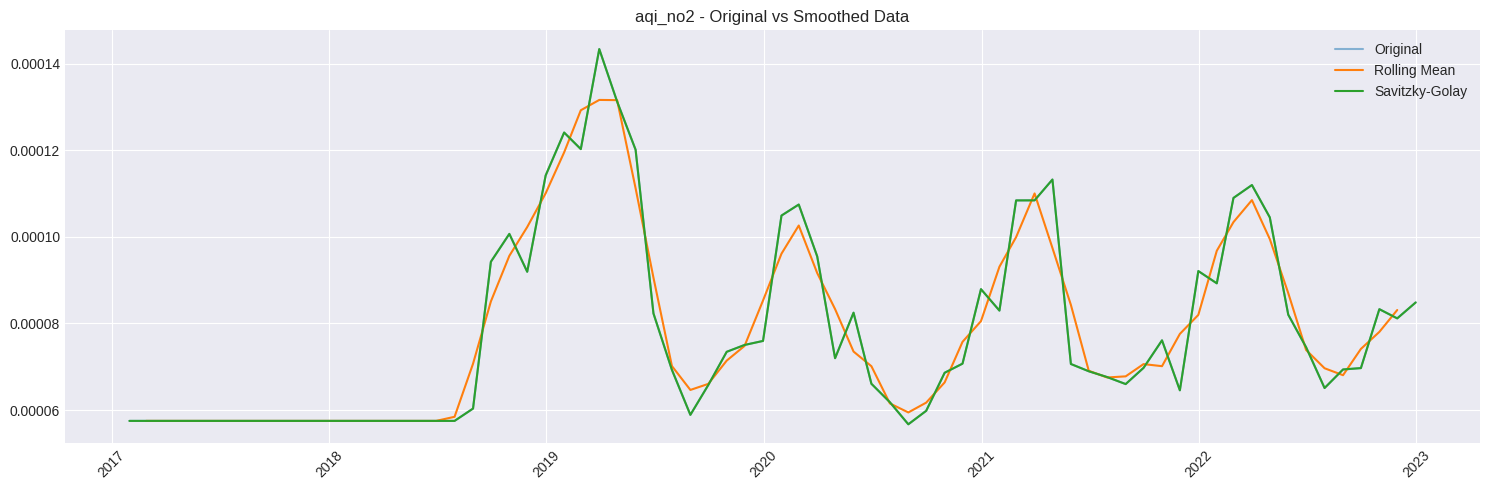

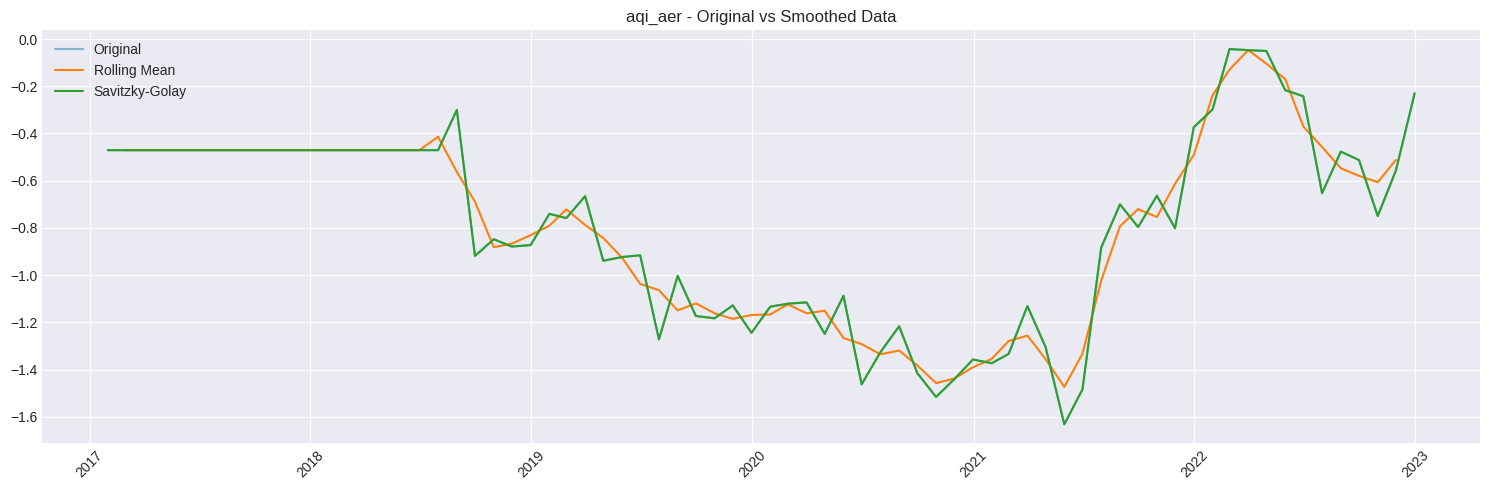

In [14]:
# Preprocessing Step 3: Data Smoothing
def apply_smoothing(df, columns, window_size=3):
    df_smoothed = df.copy()

    for column in columns:
        # Apply rolling mean
        df_smoothed[f'{column}_smoothed'] = df_smoothed[column].rolling(
            window=window_size, center=True).mean()

        # Apply Savitzky-Golay filter
        df_smoothed[f'{column}_sg'] = signal.savgol_filter(
            df_smoothed[column],
            window_length=window_size + (1 - window_size % 2),
            polyorder=2)

        # Visualization
        plt.figure(figsize=(15, 5))
        plt.plot(df_smoothed['date'], df_smoothed[column],
                label='Original', alpha=0.5)
        plt.plot(df_smoothed['date'], df_smoothed[f'{column}_smoothed'],
                label='Rolling Mean')
        plt.plot(df_smoothed['date'], df_smoothed[f'{column}_sg'],
                label='Savitzky-Golay')
        plt.title(f'{column} - Original vs Smoothed Data')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return df_smoothed

df_smoothed = apply_smoothing(df_no_outliers, variables)

Starting seasonal decomposition...
Input columns: ['NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer']

Processing NDVI...


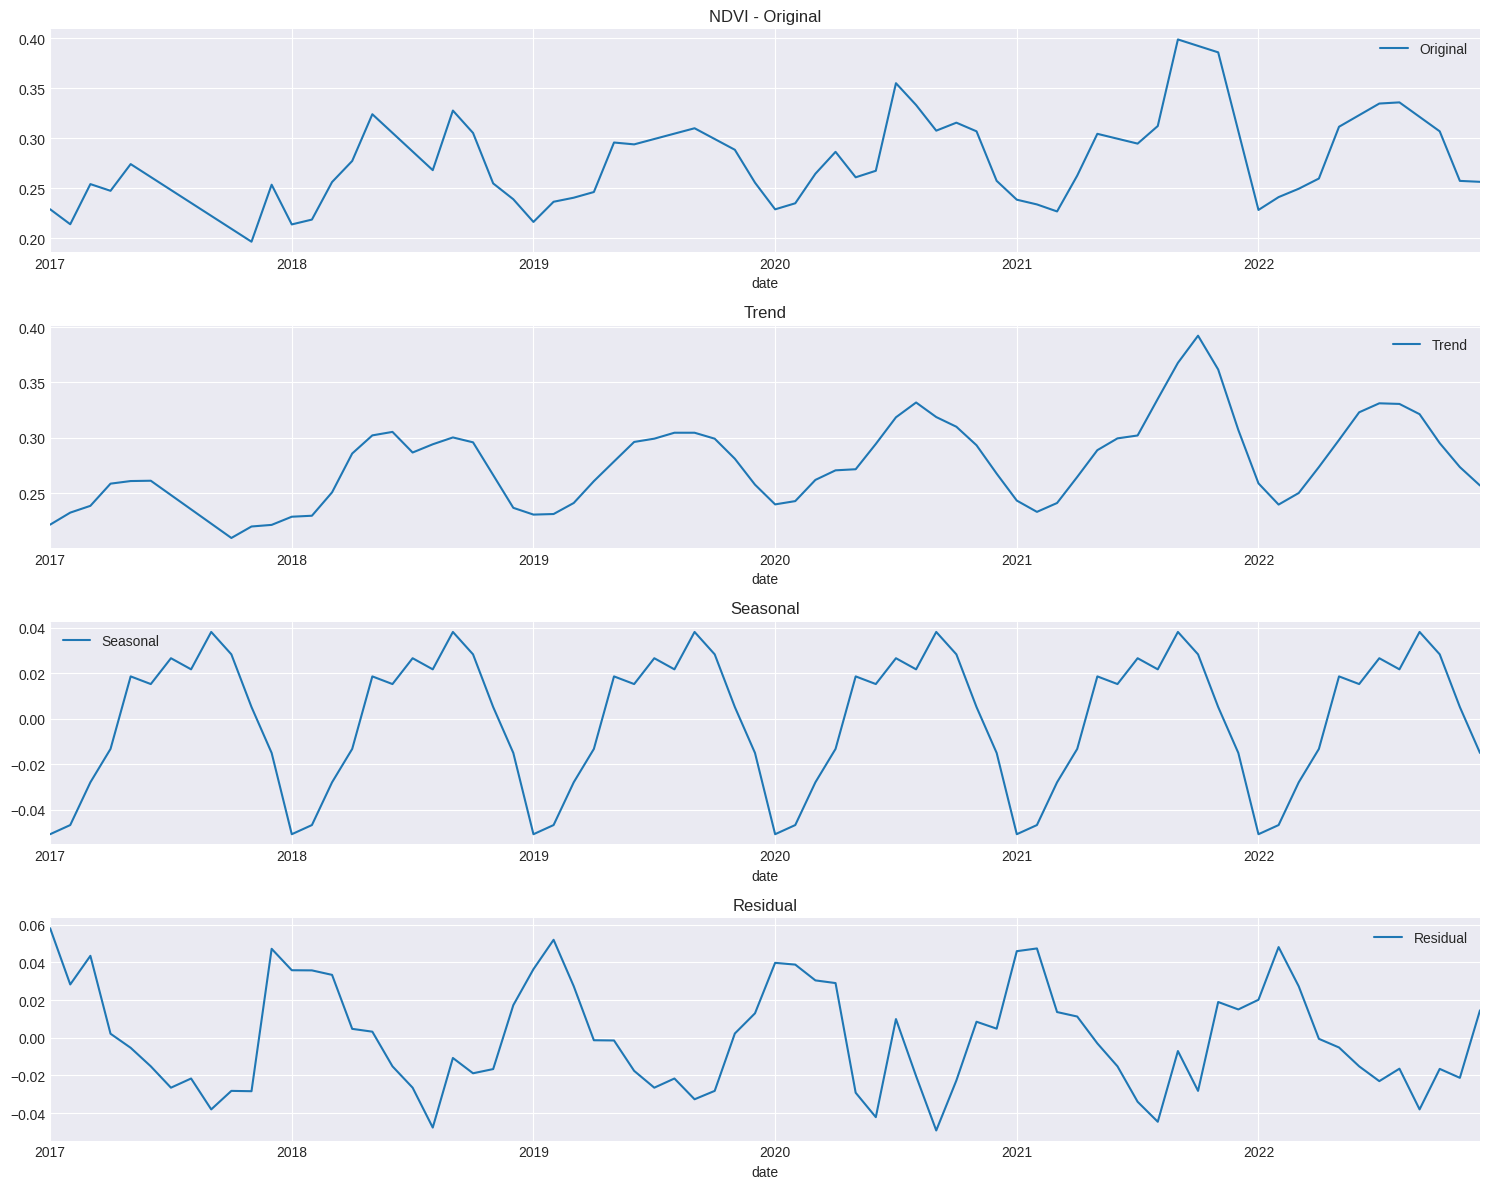


Component Statistics for NDVI:
Original mean: 0.277
Trend range: [0.209, 0.392]
Seasonal range: [-0.051, 0.038]
Residual std: 0.028

Processing temperature...


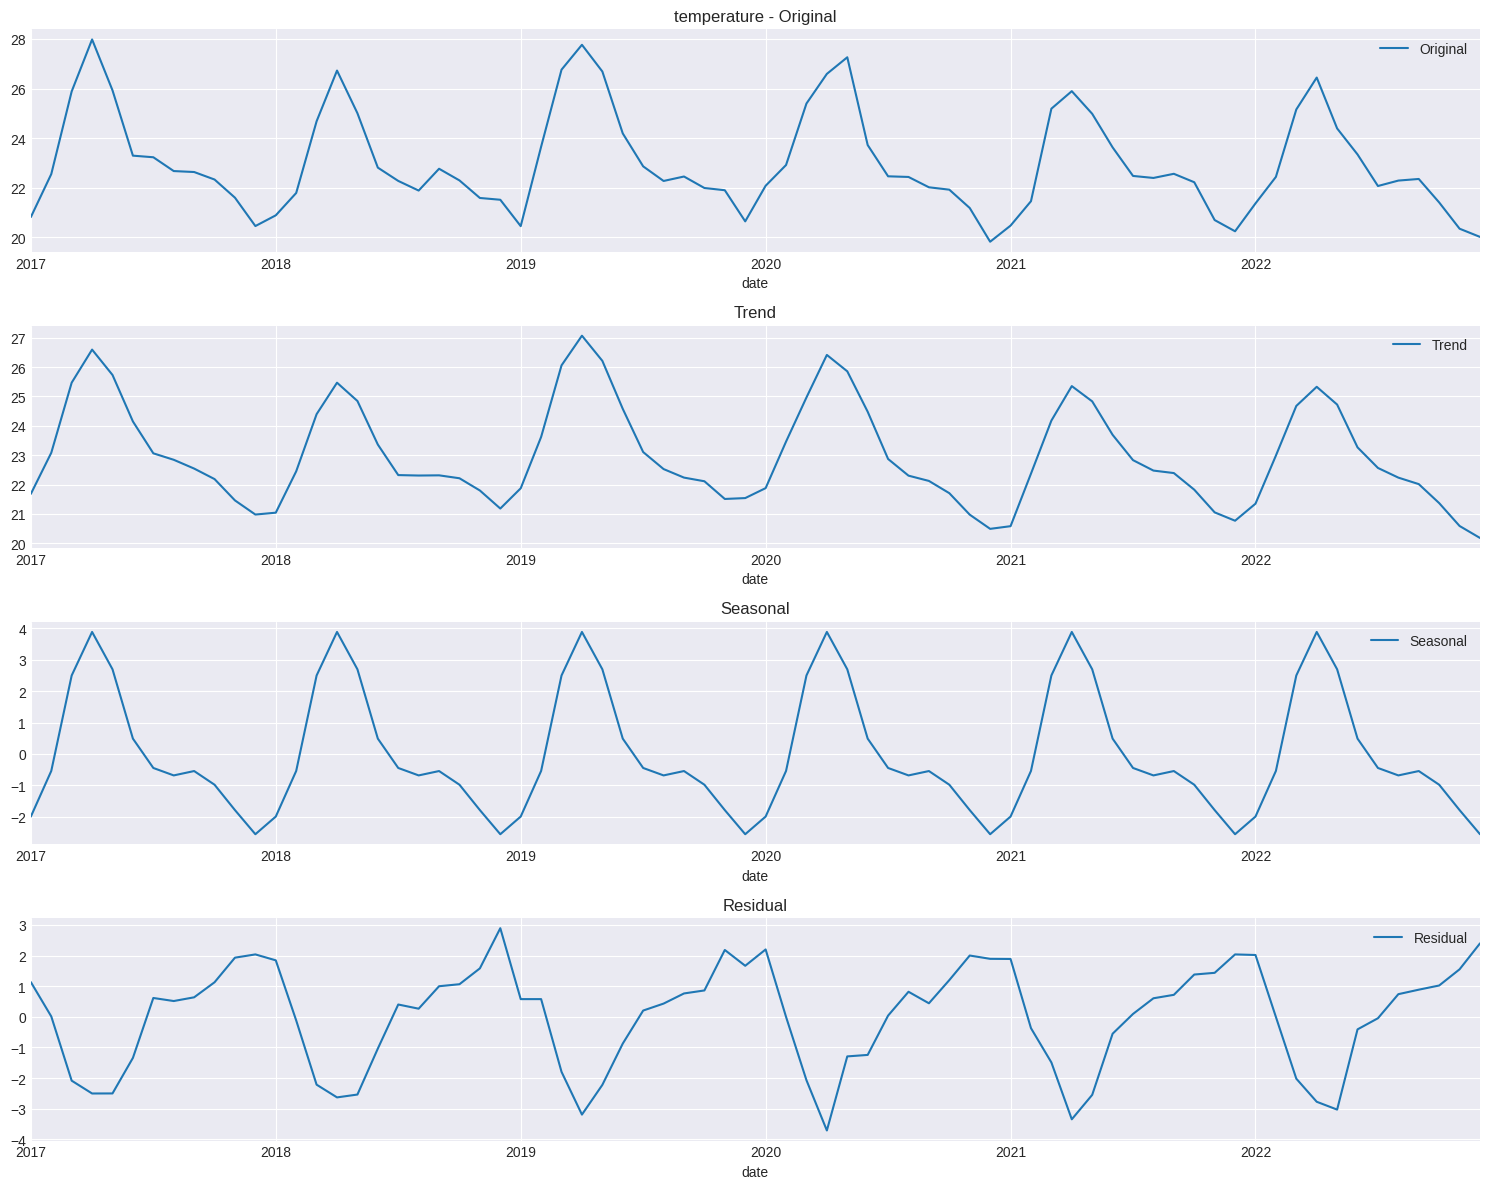


Component Statistics for temperature:
Original mean: 23.010
Trend range: [20.179, 27.071]
Seasonal range: [-2.564, 3.889]
Residual std: 1.678

Processing precipitation...


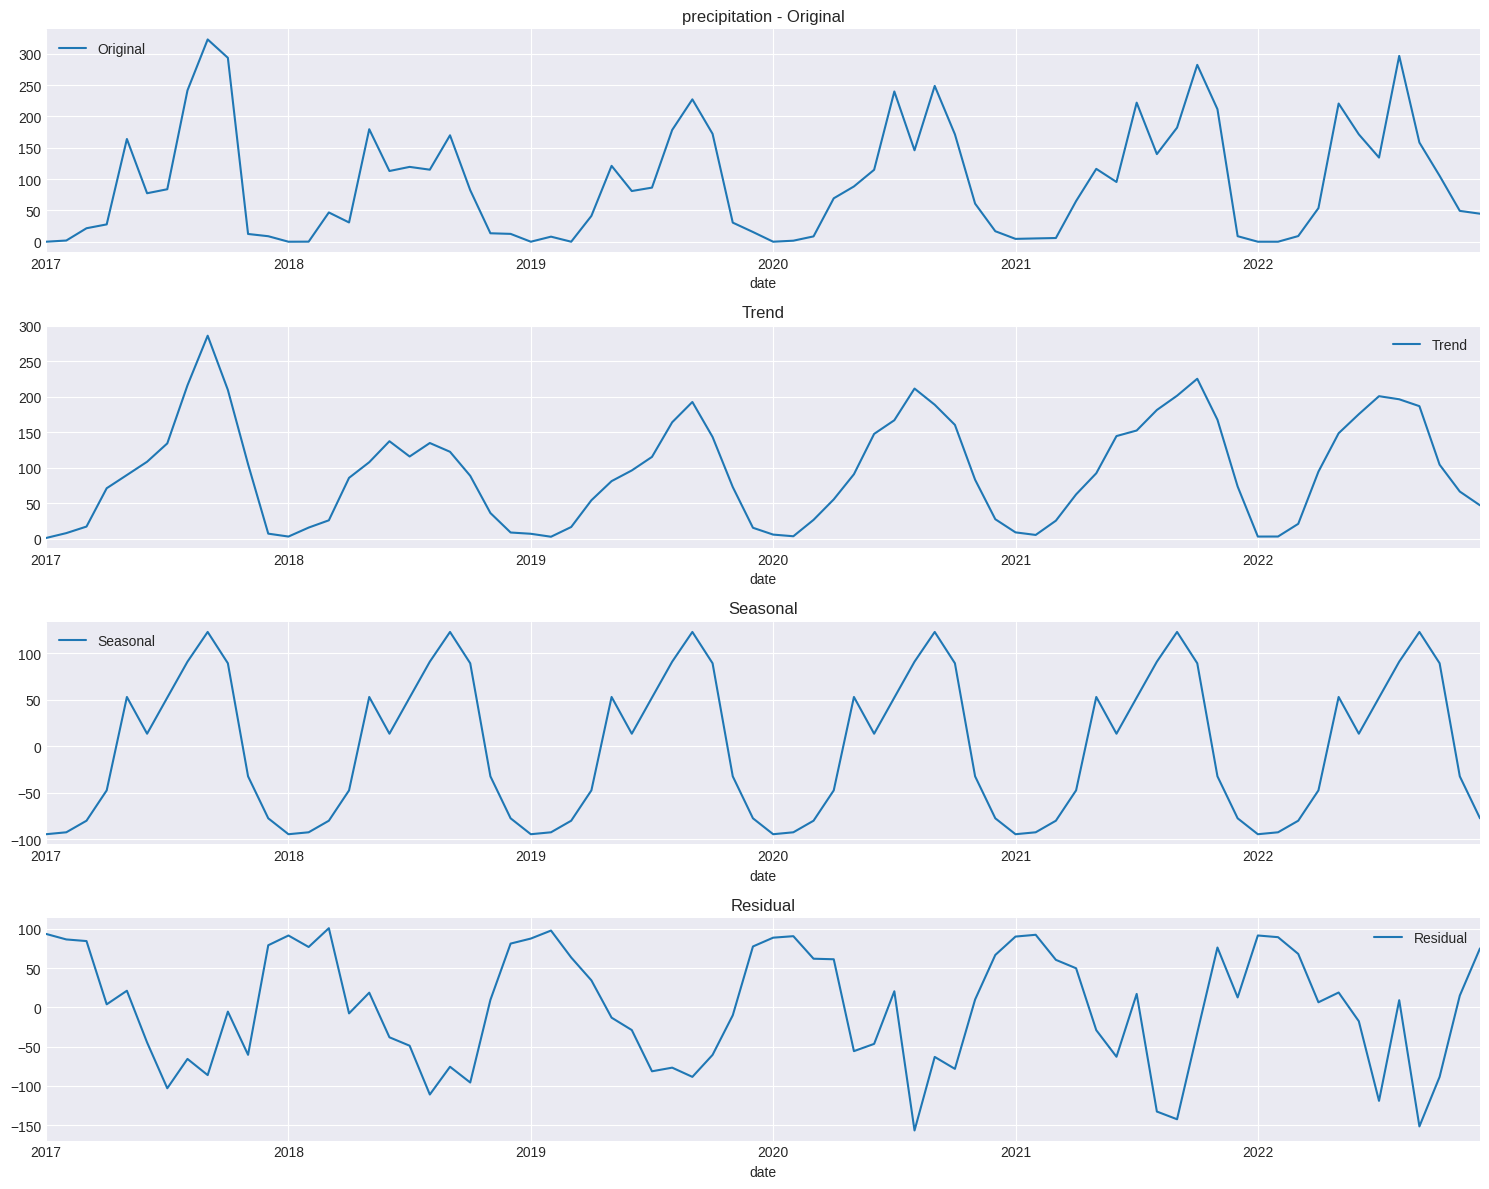


Component Statistics for precipitation:
Original mean: 95.135
Trend range: [0.967, 286.095]
Seasonal range: [-94.373, 123.126]
Residual std: 73.914

Processing aqi_no2...


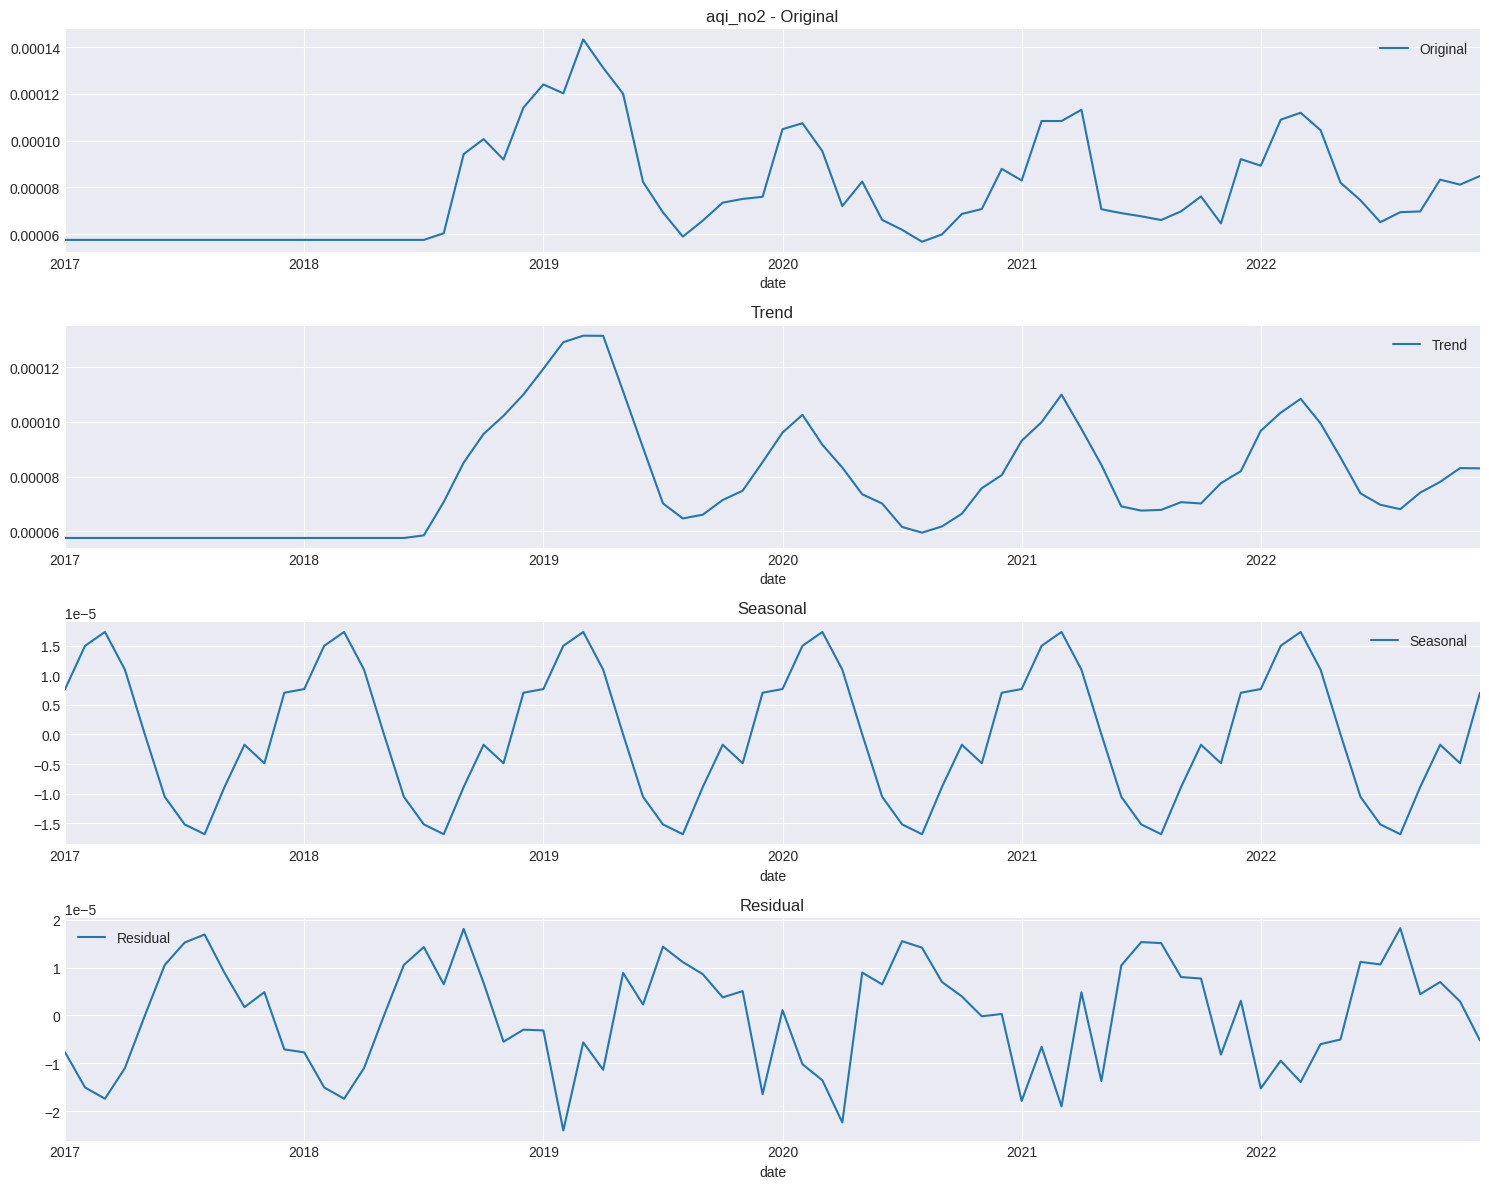


Component Statistics for aqi_no2:
Original mean: 0.000
Trend range: [0.000, 0.000]
Seasonal range: [-0.000, 0.000]
Residual std: 0.000

Processing aqi_aer...


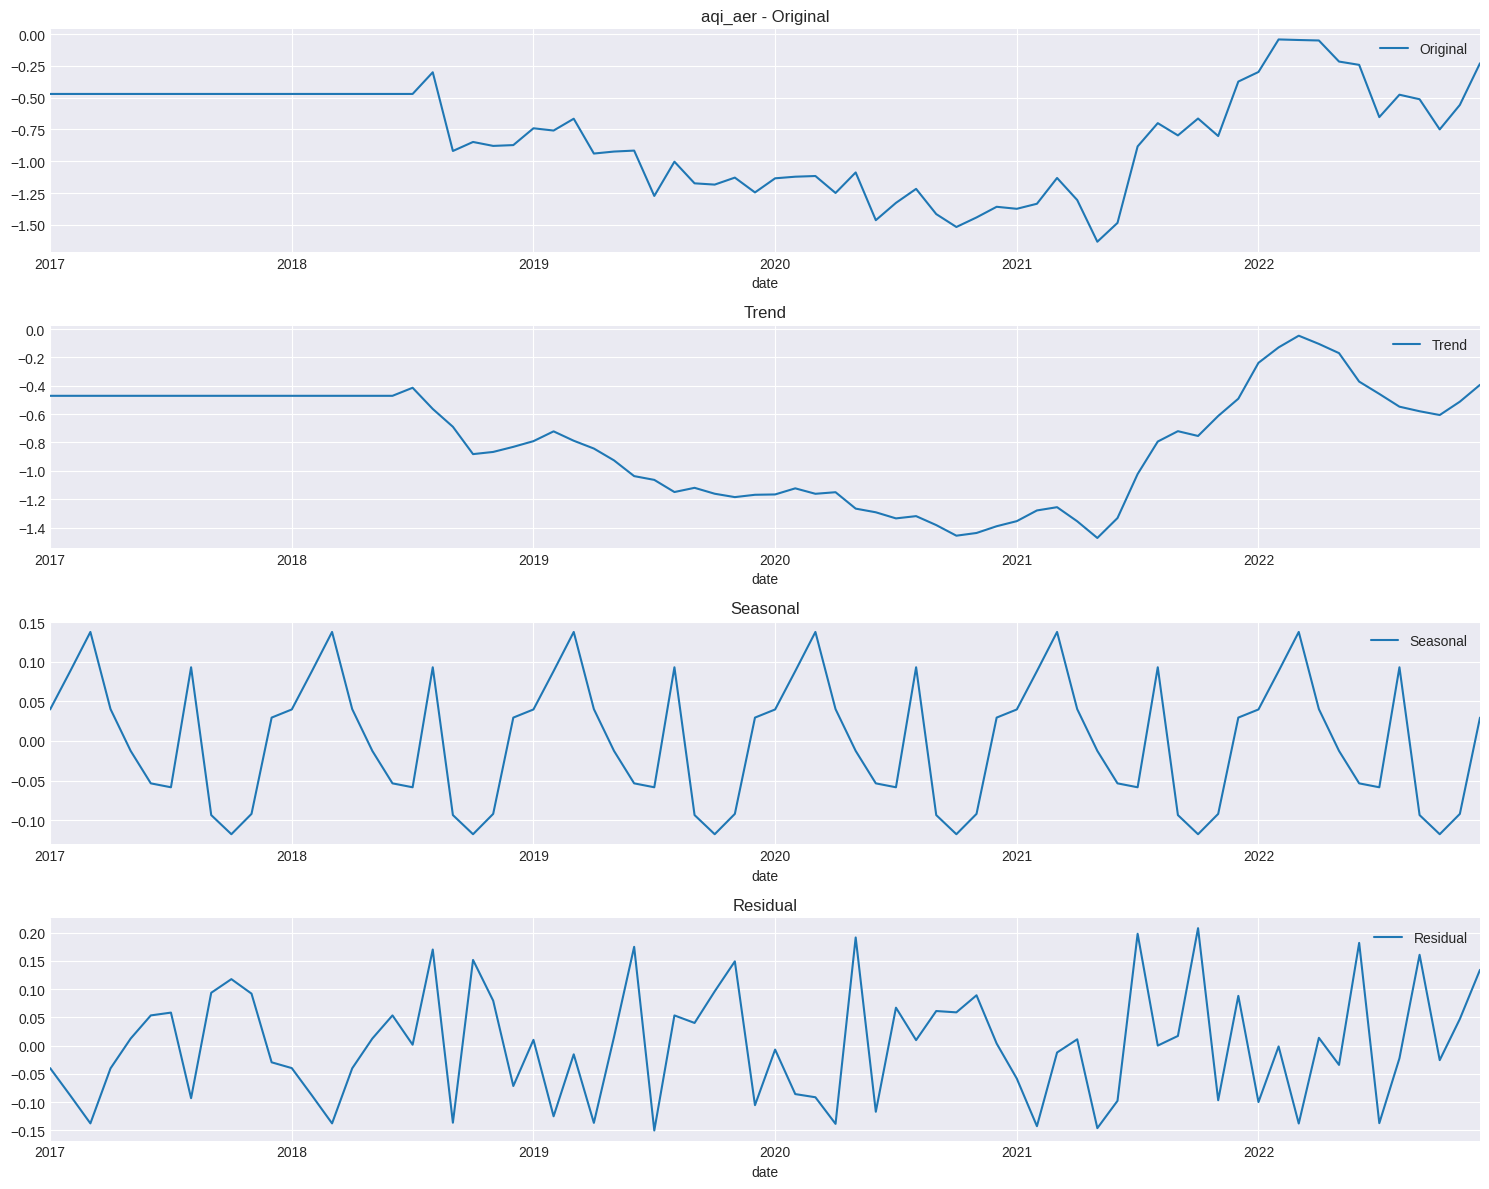


Component Statistics for aqi_aer:
Original mean: -0.788
Trend range: [-1.474, -0.047]
Seasonal range: [-0.118, 0.138]
Residual std: 0.100

Decomposition completed successfully


In [15]:
def decompose_seasonal(df, columns):
    # Create a copy and set date as index
    df_decomposed = df.copy()
    df_decomposed.set_index('date', inplace=True)

    for column in columns:
        print(f"\nProcessing {column}...")

        # Get the main series
        ts = df_decomposed[column].copy()

        # 1. Calculate trend using rolling mean
        window_size = 3
        trend = ts.rolling(window=window_size, center=True).mean()
        # Handle edge values
        trend.iloc[0] = ts.iloc[0:2].mean()
        trend.iloc[-1] = ts.iloc[-2:].mean()
        df_decomposed[f'{column}_trend'] = trend

        # 2. Calculate detrended series
        detrended = ts - trend

        # 3. Calculate seasonal pattern
        # Using month numbers directly from index
        monthly_means = pd.Series(index=range(1,13))
        for month in range(1,13):
            month_data = ts[ts.index.month == month]
            monthly_means[month] = month_data.mean()

        # Center the seasonal pattern
        seasonal_pattern = monthly_means - monthly_means.mean()

        # Create seasonal component
        seasonal = pd.Series(index=ts.index)
        for month in range(1,13):
            mask = ts.index.month == month
            seasonal[mask] = seasonal_pattern[month]
        df_decomposed[f'{column}_seasonal'] = seasonal

        # 4. Calculate residual
        df_decomposed[f'{column}_residual'] = detrended - seasonal

        # Create visualization
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))

        # Original
        ts.plot(ax=axes[0], label='Original')
        axes[0].set_title(f'{column} - Original')
        axes[0].legend()

        # Trend
        trend.plot(ax=axes[1], label='Trend')
        axes[1].set_title('Trend')
        axes[1].legend()

        # Seasonal
        seasonal.plot(ax=axes[2], label='Seasonal')
        axes[2].set_title('Seasonal')
        axes[2].legend()

        # Residual
        df_decomposed[f'{column}_residual'].plot(ax=axes[3], label='Residual')
        axes[3].set_title('Residual')
        axes[3].legend()

        plt.tight_layout()
        plt.show()

        # Print statistics with NaN handling
        print(f"\nComponent Statistics for {column}:")
        print(f"Original mean: {ts.mean():.3f}")
        print(f"Trend range: [{trend.min():.3f}, {trend.max():.3f}]")
        print(f"Seasonal range: [{seasonal.min():.3f}, {seasonal.max():.3f}]")
        print(f"Residual std: {df_decomposed[f'{column}_residual'].std():.3f}")

    # Reset index for return
    df_decomposed = df_decomposed.reset_index()
    return df_decomposed

# Run the decomposition
try:
    print("Starting seasonal decomposition...")
    print(f"Input columns: {variables}")
    df_decomposed = decompose_seasonal(df_smoothed, variables)
    print("\nDecomposition completed successfully")

except Exception as e:
    print(f"\nError in decomposition:")
    print(str(e))

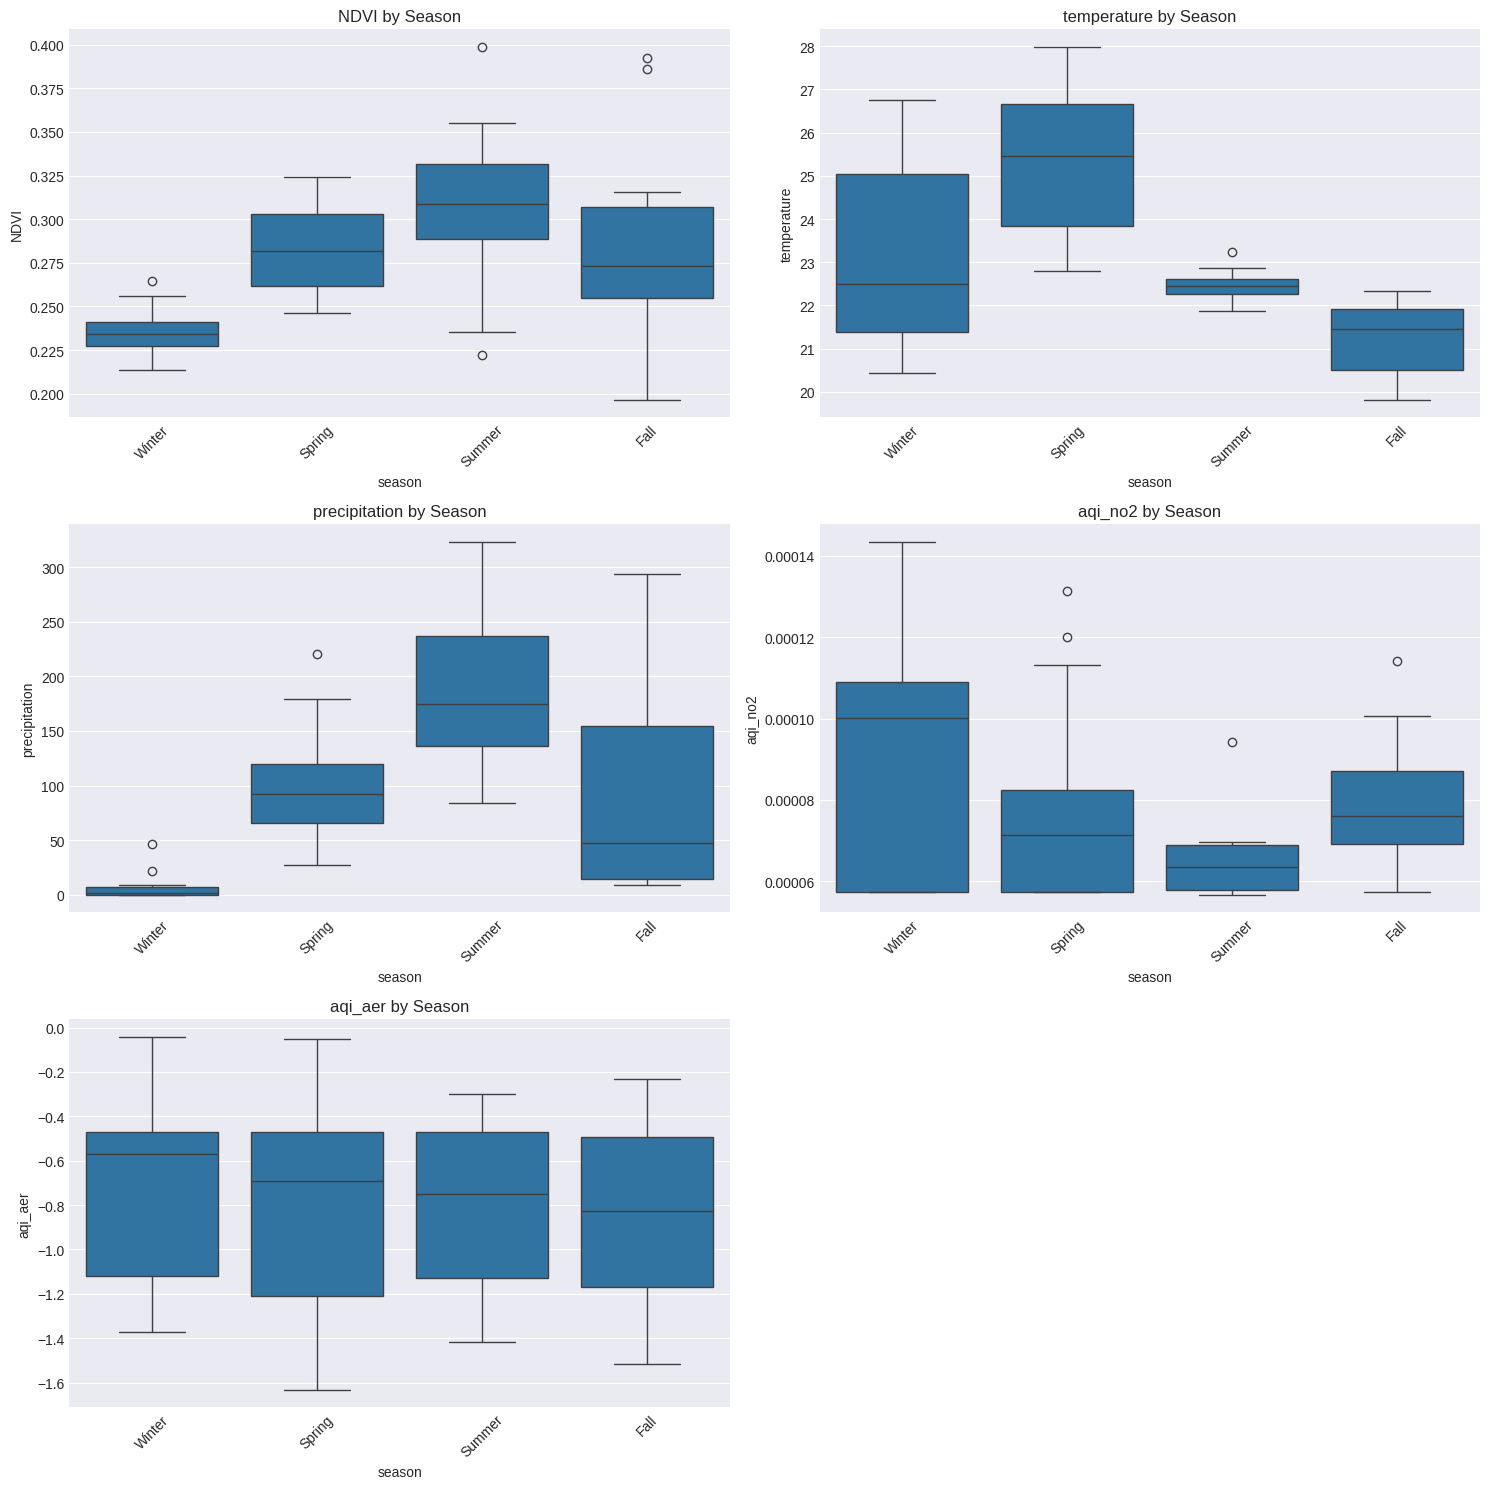

In [16]:
def engineer_features(df):
    # Only using these variables
    variables = ['NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer']

    df_engineered = df.copy()

    # Temporal features
    df_engineered['month'] = df_engineered['date'].dt.month
    df_engineered['season'] = pd.cut(df_engineered['month'],
                                   bins=[0, 3, 6, 9, 12],
                                   labels=['Winter', 'Spring', 'Summer', 'Fall'])

    # Rolling statistics
    for column in variables:
        df_engineered[f'{column}_roll_mean'] = df_engineered[column].rolling(window=2).mean()


    return df_engineered

df_engineered = engineer_features(df_decomposed)

# Calculate number of rows needed for subplots
n_vars = len(variables)
n_rows = (n_vars + 1) // 2  # Ceiling division to get number of rows needed
n_cols = min(2, n_vars)     # Use 2 columns unless we only have 1 variable

# Visualize seasonal patterns
plt.figure(figsize=(15, 5*n_rows))
for i, var in enumerate(variables, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df_engineered, x='season', y=var)
    plt.title(f'{var} by Season')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

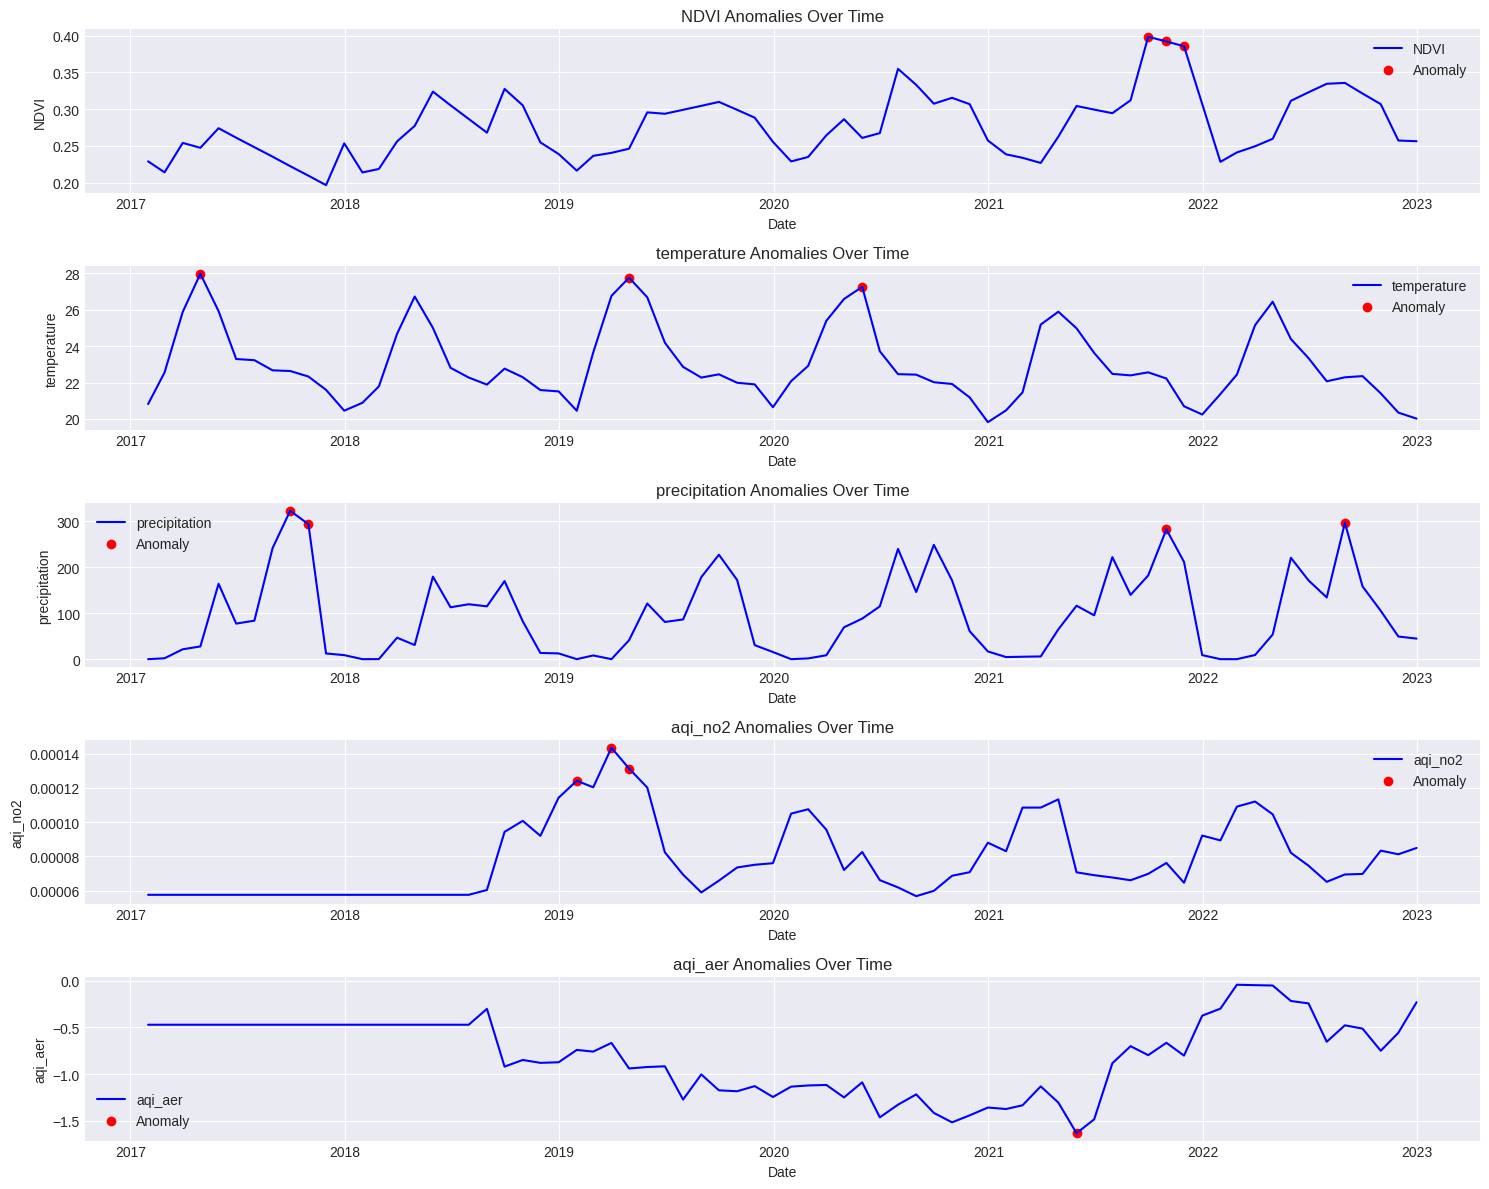

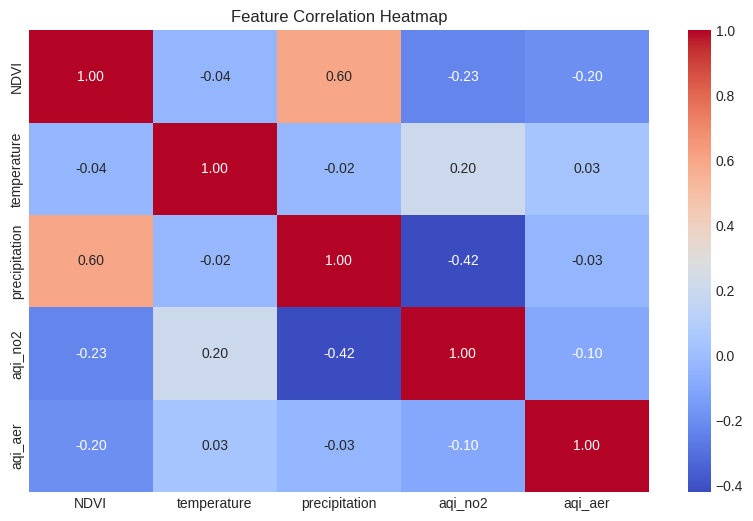

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to detect anomalies using Z-score
def detect_anomalies(df, column, threshold=2):
    mean_val = df[column].mean()
    std_dev = df[column].std()
    df[f"{column}_z_score"] = (df[column] - mean_val) / std_dev
    df[f"{column}_anomaly"] = df[f"{column}_z_score"].apply(lambda x: x > threshold or x < -threshold)
    return df

# List of variables to analyze
variables = ["NDVI", "temperature", "precipitation", "aqi_no2", "aqi_aer"]

# Detect anomalies for all variables
df_anomalies = df_engineered.copy()
for var in variables:
    df_anomalies = detect_anomalies(df_anomalies, var)

# Plot anomalies for each variable
plt.figure(figsize=(15, 12))

for i, var in enumerate(variables, 1):
    plt.subplot(len(variables), 1, i)
    plt.plot(df_anomalies["date"], df_anomalies[var], label=var, color="blue")
    plt.scatter(df_anomalies["date"][df_anomalies[f"{var}_anomaly"]],
                df_anomalies[var][df_anomalies[f"{var}_anomaly"]],
                color="red", label="Anomaly", marker="o")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.title(f"{var} Anomalies Over Time")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Create heatmap of feature correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df_engineered[variables].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


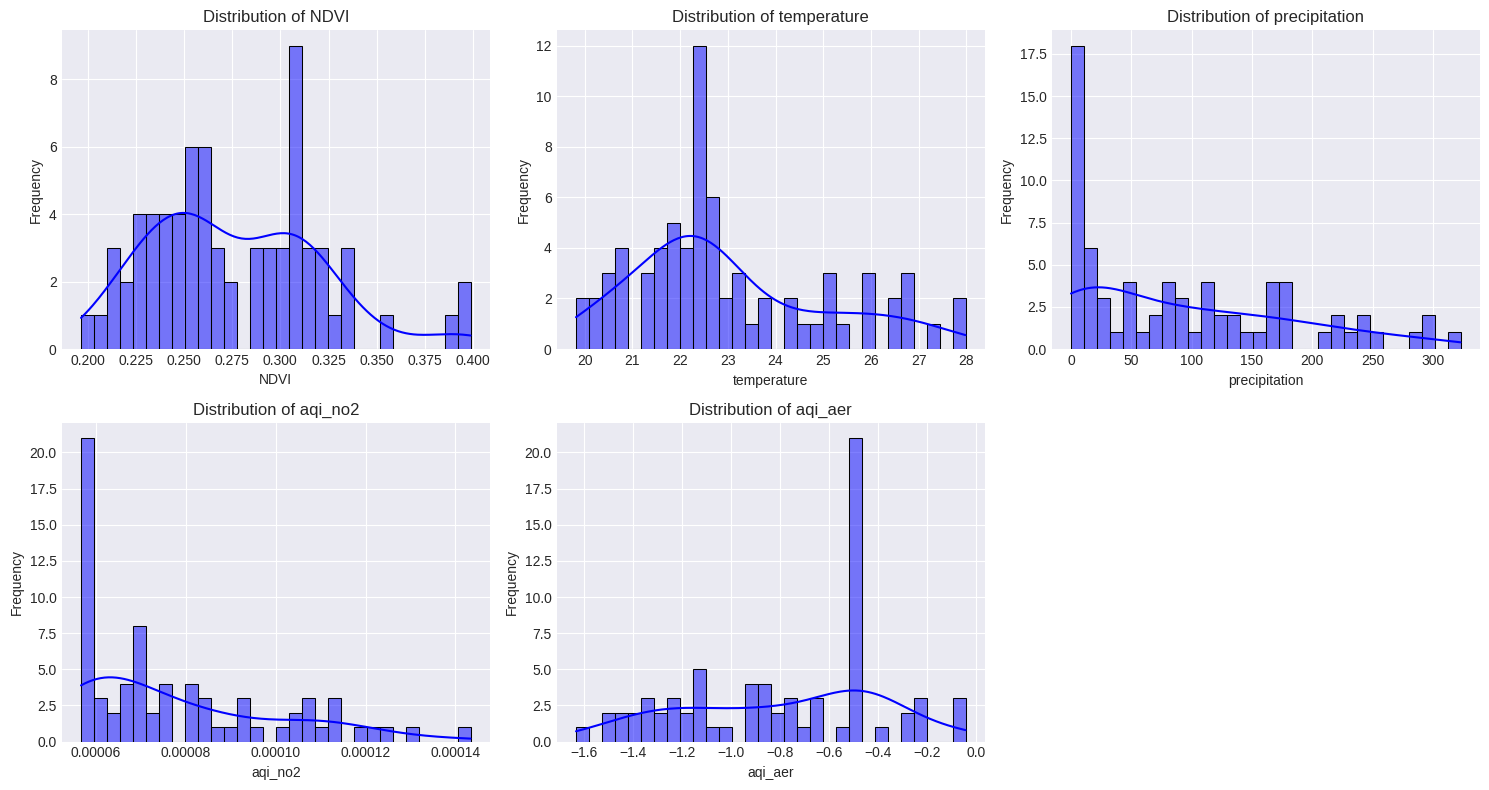

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the variables to plot
variables = ['NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer']

# Set up the figure and axes
plt.figure(figsize=(15, 8))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_engineered[var], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
print("Columns in df_engineered:", df_engineered.columns)


Columns in df_engineered: Index(['date', 'NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer',
       'NDVI_smoothed', 'NDVI_sg', 'temperature_smoothed', 'temperature_sg',
       'precipitation_smoothed', 'precipitation_sg', 'aqi_no2_smoothed',
       'aqi_no2_sg', 'aqi_aer_smoothed', 'aqi_aer_sg', 'NDVI_trend',
       'NDVI_seasonal', 'NDVI_residual', 'temperature_trend',
       'temperature_seasonal', 'temperature_residual', 'precipitation_trend',
       'precipitation_seasonal', 'precipitation_residual', 'aqi_no2_trend',
       'aqi_no2_seasonal', 'aqi_no2_residual', 'aqi_aer_trend',
       'aqi_aer_seasonal', 'aqi_aer_residual', 'month', 'season',
       'NDVI_roll_mean', 'temperature_roll_mean', 'precipitation_roll_mean',
       'aqi_no2_roll_mean', 'aqi_aer_roll_mean'],
      dtype='object')


In [ ]:
!pip install rasterio


Training models for NDVI...


<ipython-input-24-342813caa6f8>:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving avera

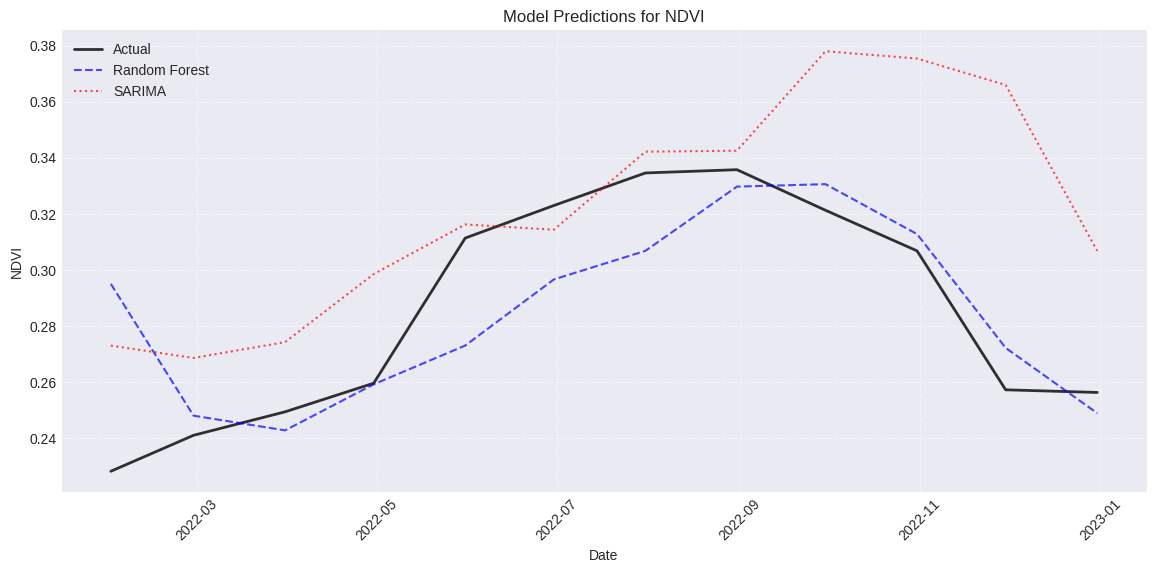


Model Performance for NDVI:
Random Forest - RMSE: 0.0257, R²: 0.5501
SARIMA - RMSE: 0.0477, R²: -0.5541

Training models for temperature...


<ipython-input-24-342813caa6f8>:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


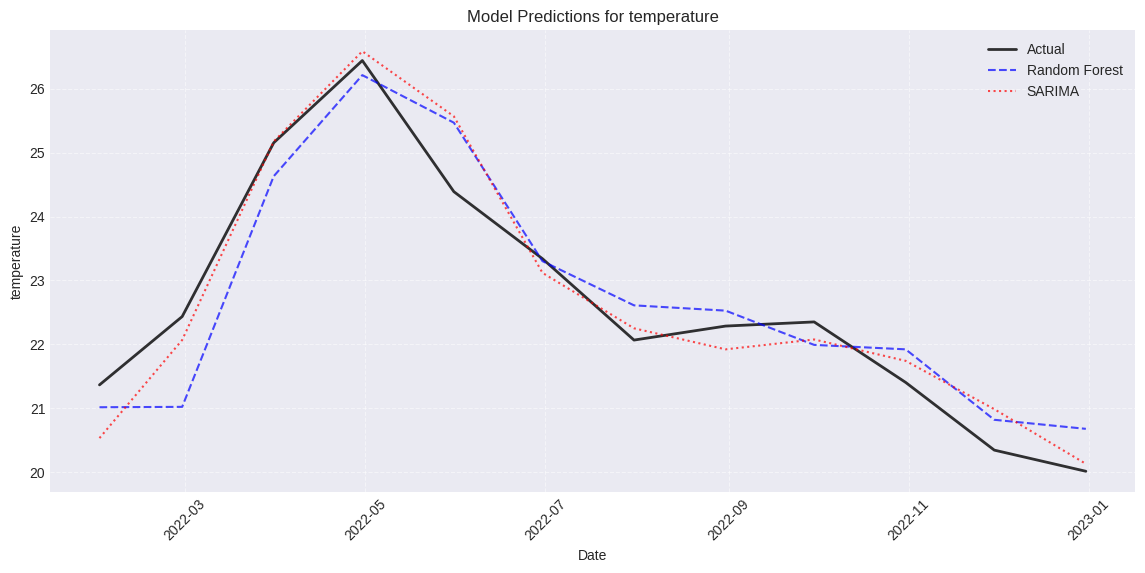


Model Performance for temperature:
Random Forest - RMSE: 0.6475, R²: 0.8749
SARIMA - RMSE: 0.5056, R²: 0.9237

Training models for precipitation...


<ipython-input-24-342813caa6f8>:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


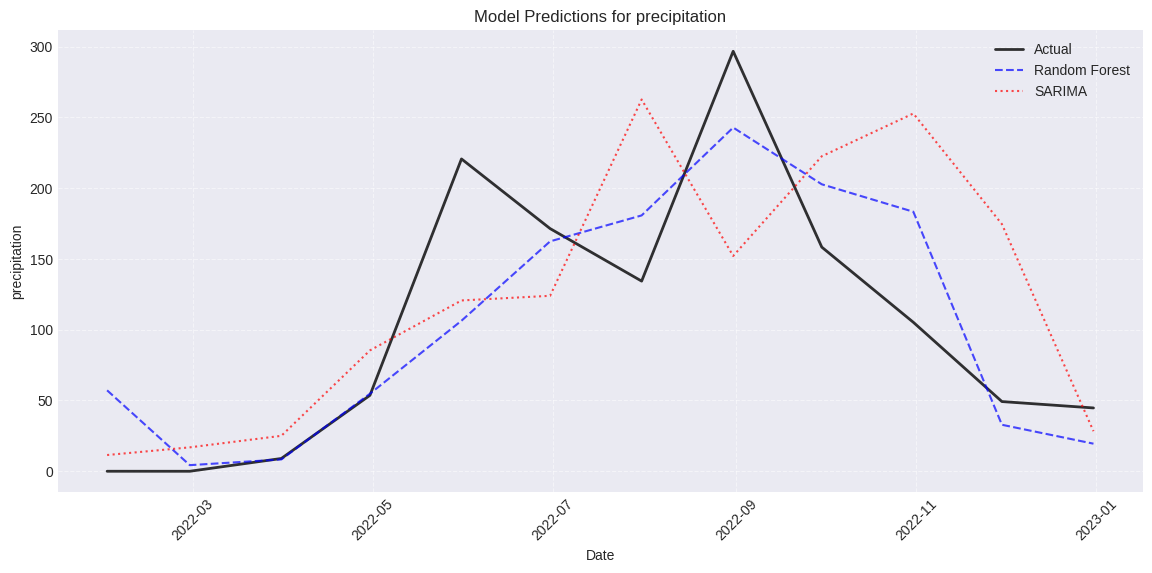


Model Performance for precipitation:
Random Forest - RMSE: 50.3880, R²: 0.6918
SARIMA - RMSE: 88.1081, R²: 0.0577

Training models for aqi_no2...


<ipython-input-24-342813caa6f8>:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

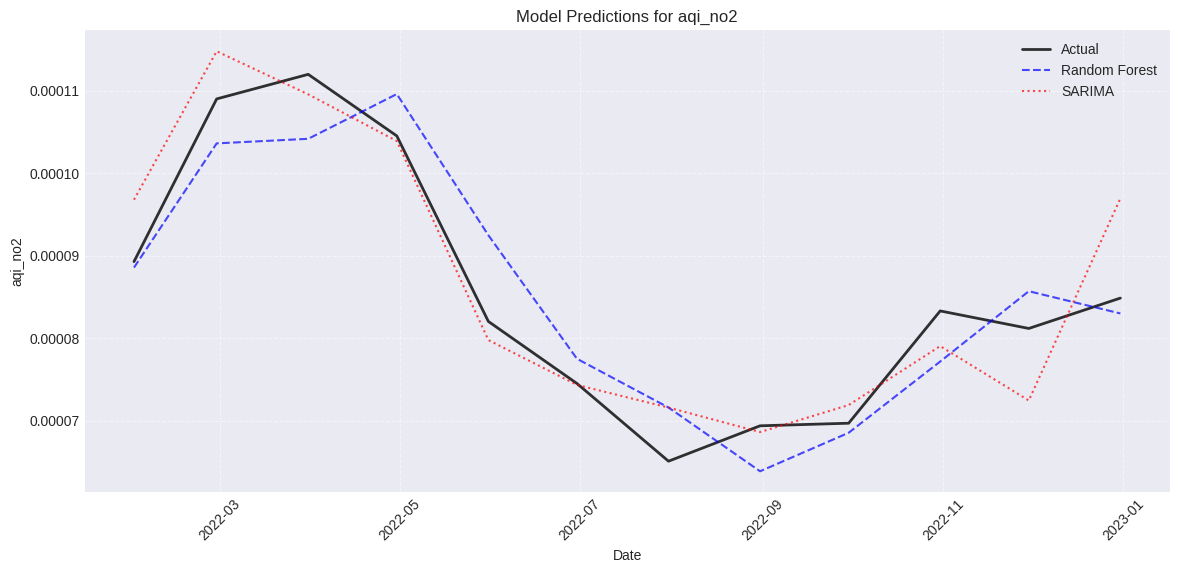


Model Performance for aqi_no2:
Random Forest - RMSE: 0.0000, R²: 0.8636
SARIMA - RMSE: 0.0000, R²: 0.8566

Training models for aqi_aer...


<ipython-input-24-342813caa6f8>:109: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


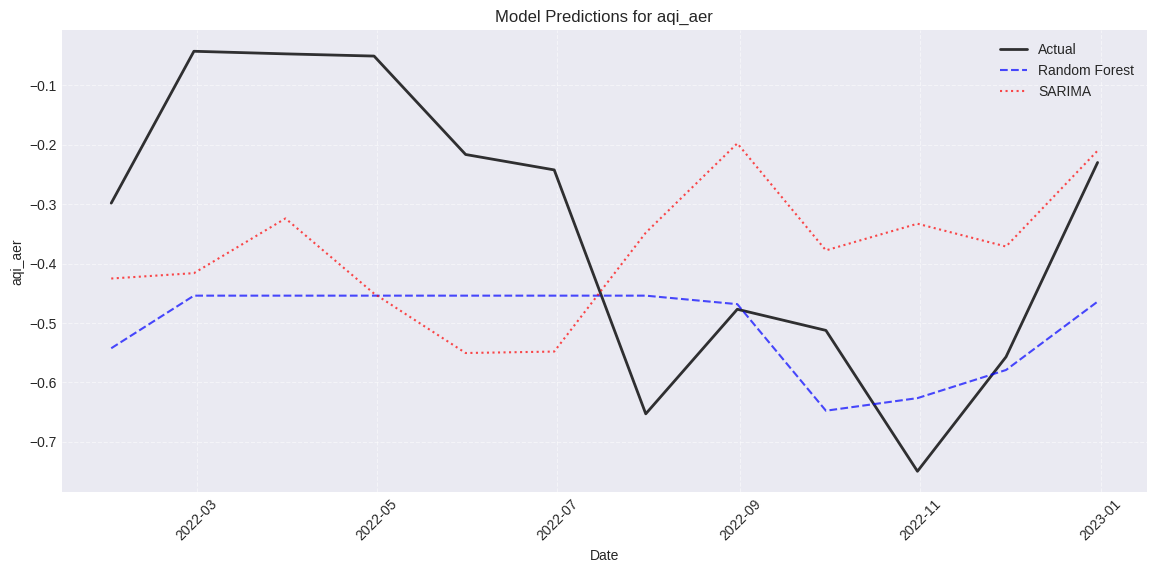


Model Performance for aqi_aer:
Random Forest - RMSE: 0.2561, R²: -0.1960
SARIMA - RMSE: 0.2880, R²: -0.5122


In [24]:
# # # # Prepare data for modeling
# # Import Libraries
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import TimeSeriesSplit
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Prepare Data for Modeling
# def prepare_modeling_data(df, target_variable):
#     # Consider adding more features for better performance
#     feature_cols = ['month']  # Add lag features, rolling means, etc.

#     X = df[feature_cols]
#     y = df[target_variable]

#     # TimeSeriesSplit for better evaluation
#     tscv = TimeSeriesSplit(n_splits=5)
#     train_idx, test_idx = list(tscv.split(X))[-1]  # Get last split

#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#     return X_train, X_test, y_train, y_test, feature_cols

# # Train and Evaluate Models
# def train_and_evaluate_models(X_train, X_test, y_train, y_test, target_variable):
#     # Random Forest Model
#     rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#     rf_model.fit(X_train, y_train)
#     rf_pred = rf_model.predict(X_test)
#     rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
#     rf_r2 = r2_score(y_test, rf_pred)

#     # SARIMA Model
#     sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
#     sarima_fitted = sarima_model.fit(disp=False)
#     sarima_pred = sarima_fitted.forecast(steps=len(y_test))  # Forecasting
#     sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))
#     sarima_r2 = r2_score(y_test, sarima_pred)

#     # Plot results
#     plt.figure(figsize=(14, 6))
#     plt.plot(y_test.index, y_test, 'k-', label='Actual', alpha=0.8, linewidth=2)
#     plt.plot(y_test.index, rf_pred, 'b-', label='Random Forest', alpha=0.7, linestyle='dashed')
#     plt.plot(y_test.index, sarima_pred, 'r-', label='SARIMA', alpha=0.7, linestyle='dotted')

#     plt.xlabel("Date")
#     plt.ylabel(target_variable)
#     plt.title(f'Model Predictions for {target_variable}')
#     plt.legend(loc="best")  # Better legend positioning
#     plt.xticks(rotation=45)
#     plt.grid(True, linestyle="--", alpha=0.5)
#     plt.show()

#     # Print metrics
#     print(f"\nModel Performance for {target_variable}:")
#     print(f"Random Forest - RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
#     print(f"SARIMA - RMSE: {sarima_rmse:.4f}, R²: {sarima_r2:.4f}")

#     return rf_model, sarima_fitted, rf_rmse, sarima_rmse

# # Train Models for Each Variable
# variables = ['NDVI', 'temperature', 'precipitation', 'aqi_no2', 'aqi_aer']
# model_results = {}

# for var in variables:
#     print(f"\nTraining models for {var}...")
#     X_train, X_test, y_train, y_test, feature_cols = prepare_modeling_data(df_engineered, var)

#     rf_model, sarima_model, rf_rmse, sarima_rmse = train_and_evaluate_models(
#         X_train, X_test, y_train, y_test, var
#     )

#     model_results[var] = {
#         'random_forest': {'model': rf_model, 'rmse': rf_rmse},
#         'sarima': {'model': sarima_model, 'rmse': sarima_rmse}
#     }





# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare Data for Modeling
def prepare_modeling_data(df, target_variable):
    df = df.copy()  # Prevent modifying original data

    # Ensure Date is in datetime format
    df["date"] = pd.to_datetime(df["date"])  # Use lowercase "date"
    df.set_index("date", inplace=True)

    # Feature Engineering: Adding Lag & Rolling Mean Features
    df["month"] = df.index.month
    df[f"{target_variable}_lag1"] = df[target_variable].shift(1)
    df[f"{target_variable}_rolling3"] = df[target_variable].rolling(window=3).mean()

    # Fill missing values using forward fill method
    df.fillna(method="ffill", inplace=True)

    feature_cols = ["month", f"{target_variable}_lag1", f"{target_variable}_rolling3"]

    X = df[feature_cols]
    y = df[target_variable]

    # TimeSeriesSplit for better evaluation
    tscv = TimeSeriesSplit(n_splits=5)

    # Ensure sufficient data before splitting
    if len(X) < 10:  # Arbitrary minimum data size
        raise ValueError(f"Not enough data for {target_variable} (only {len(X)} records available).")

    train_idx, test_idx = list(tscv.split(X))[-1]  # Get last split

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    return X_train, X_test, y_train, y_test, feature_cols

# Train and Evaluate Models
def train_and_evaluate_models(X_train, X_test, y_train, y_test, target_variable):
    # Random Forest Model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    rf_r2 = r2_score(y_test, rf_pred)

    # SARIMA Model
    sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_fitted = sarima_model.fit(method="lbfgs", disp=False)  # Use modern fitting method

    # Forecast SARIMA for exact test period
    sarima_pred = sarima_fitted.get_forecast(steps=len(y_test)).predicted_mean
    sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))
    sarima_r2 = r2_score(y_test, sarima_pred)

    # Plot results
    plt.figure(figsize=(14, 6))
    plt.plot(y_test.index, y_test, "k-", label="Actual", alpha=0.8, linewidth=2)
    plt.plot(y_test.index, rf_pred, "b--", label="Random Forest", alpha=0.7)
    plt.plot(y_test.index, sarima_pred, "r:", label="SARIMA", alpha=0.7)

    plt.xlabel("Date")
    plt.ylabel(target_variable)
    plt.title(f'Model Predictions for {target_variable}')
    plt.legend(loc="best")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Print metrics
    print(f"\nModel Performance for {target_variable}:")
    print(f"Random Forest - RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")
    print(f"SARIMA - RMSE: {sarima_rmse:.4f}, R²: {sarima_r2:.4f}")

    return rf_model, sarima_fitted, rf_rmse, sarima_rmse

# Train Models for Each Variable
variables = ["NDVI", "temperature", "precipitation", "aqi_no2", "aqi_aer"]
model_results = {}

for var in variables:
    print(f"\nTraining models for {var}...")
    try:
        X_train, X_test, y_train, y_test, feature_cols = prepare_modeling_data(df_engineered, var)

        rf_model, sarima_model, rf_rmse, sarima_rmse = train_and_evaluate_models(
            X_train, X_test, y_train, y_test, var
        )

        model_results[var] = {
            "random_forest": {"model": rf_model, "rmse": rf_rmse},
            "sarima": {"model": sarima_model, "rmse": sarima_rmse},
        }
    except ValueError as e:
        print(f"Skipping {var} due to error: {e}")



In [ ]:
import pickle
import os

# Create a directory to store the models if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save NDVI models
# Random Forest
with open('saved_models/ndvi_rf_model.pkl', 'wb') as f:
    pickle.dump(model_results['NDVI']['random_forest']['model'], f)

# SARIMA
model_results['NDVI']['sarima']['model'].save('saved_models/ndvi_sarima_model.pkl')

# Save Temperature models
# Random Forest
with open('saved_models/temperature_rf_model.pkl', 'wb') as f:
    pickle.dump(model_results['temperature']['random_forest']['model'], f)

# SARIMA
model_results['temperature']['sarima']['model'].save('saved_models/temperature_sarima_model.pkl')

print("Models saved successfully!")

# To load the models later, you can use:
"""
# Load Random Forest models
with open('saved_models/ndvi_rf_model.pkl', 'rb') as f:
    ndvi_rf_model = pickle.load(f)

with open('saved_models/temperature_rf_model.pkl', 'rb') as f:
    temperature_rf_model = pickle.load(f)

# Load SARIMA models
from statsmodels.tsa.statespace.sarimax import SARIMAX
ndvi_sarima_model = SARIMAX.load('saved_models/ndvi_sarima_model.pkl')
temperature_sarima_model = SARIMAX.load('saved_models/temperature_sarima_model.pkl')
"""